# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

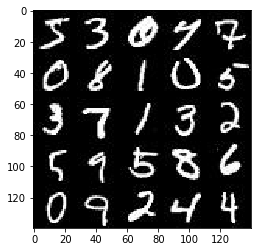

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

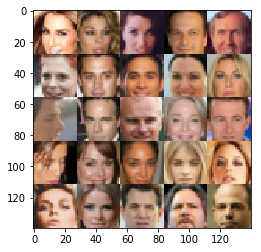

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        layers = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layers = tf.maximum(alpha * layers, layers)

        layers = tf.layers.conv2d(layers, 128, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=True)
        layers = tf.maximum(alpha * layers, layers)

        layers = tf.layers.conv2d(layers, 256, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=True)
        layers = tf.maximum(alpha * layers, layers)
        
        layers = tf.layers.conv2d(layers, 512, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=True)
        layers = tf.maximum(alpha * layers, layers)
        
        flatten = tf.reshape(layers, (-1, 2 * 2 * 512))
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        layers = tf.layers.dense(z, 4*4*1024)
        layers = tf.reshape(layers, (-1, 4, 4, 1024))
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)

        layers = tf.layers.conv2d_transpose(layers, 512, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)
                
        layers = tf.layers.conv2d_transpose(layers, 256, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)

        layers = tf.layers.conv2d_transpose(layers, 128, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)

        layers = tf.layers.conv2d_transpose(layers, 64, 5, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)

        layers = tf.layers.conv2d_transpose(layers, out_channel_dim, 3, strides=2, padding='same')
        layers = tf.image.resize_images(layers, size=(28, 28))
        
        output = tf.nn.tanh(layers)
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                          labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print("Parameters:")
    print("epoch_count: {}".format(epoch_count))
    print("batch_size: {}".format(batch_size))
    print("z_dim: {}".format(z_dim))
    print("learning_rate: {}".format(learning_rate))
    print("beta1: {}".format(beta1))
    print("data_shape: {}".format(data_shape))
    
    if data_image_mode == "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print("Getting model inputs... Ok")
    
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    print("Calculating model loss... Ok")
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    print("Getting model optimizers ... Ok")

    count = 1;    
    t = time.process_time()

    losses = []
    print("Starting training")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                sess.run(d_opt, feed_dict = {lr: learning_rate, real_input: batch_images, z_input : batch_z})
                sess.run(g_opt, feed_dict = {lr: learning_rate, z_input: batch_z})
                
                if count % (10 * epoch_count) == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    losses.append((train_loss_d, train_loss_g))
                    elapsed_time = time.process_time() - t
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, count),
                          "d_loss: {:.4f}...".format(train_loss_d),
                          "g_loss: {:.4f}".format(train_loss_g),
                          "Elapsed: {0:g}m{0:g}s".format(elapsed_time//60,elapsed_time % 60))
                    
                if count % (100 * epoch_count) == 0:
                    print("Sample output")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)

                count +=1
    
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator')
    pyplot.plot(losses.T[1], label='Generator')
    pyplot.title("Training Losses")
    pyplot.legend()
    print("Training done")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Parameters:
epoch_count: 2
batch_size: 32
z_dim: 100
learning_rate: 0.0002
beta1: 0.5
data_shape: (60000, 28, 28, 1)
Getting model inputs... Ok
Calculating model loss... Ok
Getting model optimizers ... Ok
Starting training
Epoch 1/2... Step 10... d_loss: 0.3816... g_loss: 4.0308 Elapsed: 0m0s
Epoch 1/2... Step 20... d_loss: 0.3745... g_loss: 7.2623 Elapsed: 0m0s
Epoch 1/2... Step 30... d_loss: 4.2827... g_loss: 0.0264 Elapsed: 0m0s
Epoch 1/2... Step 40... d_loss: 0.3849... g_loss: 5.2921 Elapsed: 0m0s
Epoch 1/2... Step 50... d_loss: 0.5306... g_loss: 2.6153 Elapsed: 0m0s
Epoch 1/2... Step 60... d_loss: 1.5188... g_loss: 0.6248 Elapsed: 0m0s
Epoch 1/2... Step 70... d_loss: 0.6126... g_loss: 1.7642 Elapsed: 0m0s
Epoch 1/2... Step 80... d_loss: 0.6624... g_loss: 2.4011 Elapsed: 1m1s
Epoch 1/2... Step 90... d_loss: 0.6940... g_loss: 1.9234 Elapsed: 1m1s
Epoch 1/2... Step 100... d_loss: 0.6124... g_loss: 1.9495 Elapsed: 1m1s
Sample output


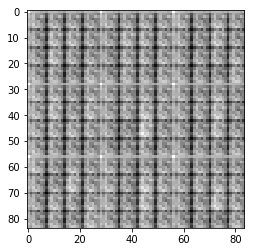

Epoch 1/2... Step 110... d_loss: 2.1029... g_loss: 0.3019 Elapsed: 1m1s
Epoch 1/2... Step 120... d_loss: 1.1066... g_loss: 0.7584 Elapsed: 1m1s
Epoch 1/2... Step 130... d_loss: 1.0962... g_loss: 1.9052 Elapsed: 1m1s
Epoch 1/2... Step 140... d_loss: 1.0783... g_loss: 1.0431 Elapsed: 1m1s
Epoch 1/2... Step 150... d_loss: 1.4962... g_loss: 1.1628 Elapsed: 2m2s
Epoch 1/2... Step 160... d_loss: 0.8714... g_loss: 1.2878 Elapsed: 2m2s
Epoch 1/2... Step 170... d_loss: 1.2181... g_loss: 0.7723 Elapsed: 2m2s
Epoch 1/2... Step 180... d_loss: 1.3968... g_loss: 0.5447 Elapsed: 2m2s
Epoch 1/2... Step 190... d_loss: 0.7464... g_loss: 1.8151 Elapsed: 2m2s
Epoch 1/2... Step 200... d_loss: 1.1052... g_loss: 0.9806 Elapsed: 2m2s
Sample output


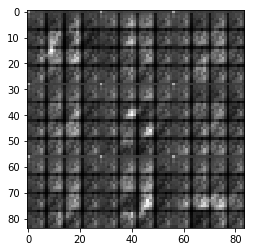

Epoch 1/2... Step 210... d_loss: 1.3715... g_loss: 2.6731 Elapsed: 2m2s
Epoch 1/2... Step 220... d_loss: 1.2030... g_loss: 1.1743 Elapsed: 2m2s
Epoch 1/2... Step 230... d_loss: 1.0306... g_loss: 1.6676 Elapsed: 3m3s
Epoch 1/2... Step 240... d_loss: 1.0061... g_loss: 1.2272 Elapsed: 3m3s
Epoch 1/2... Step 250... d_loss: 1.1943... g_loss: 2.2028 Elapsed: 3m3s
Epoch 1/2... Step 260... d_loss: 0.8428... g_loss: 1.5321 Elapsed: 3m3s
Epoch 1/2... Step 270... d_loss: 0.7759... g_loss: 1.3766 Elapsed: 3m3s
Epoch 1/2... Step 280... d_loss: 1.0985... g_loss: 0.7643 Elapsed: 3m3s
Epoch 1/2... Step 290... d_loss: 0.8463... g_loss: 1.4593 Elapsed: 3m3s
Epoch 1/2... Step 300... d_loss: 1.4415... g_loss: 0.5106 Elapsed: 3m3s
Sample output


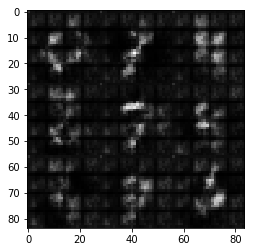

Epoch 1/2... Step 310... d_loss: 1.2587... g_loss: 0.6577 Elapsed: 4m4s
Epoch 1/2... Step 320... d_loss: 1.2767... g_loss: 0.7671 Elapsed: 4m4s
Epoch 1/2... Step 330... d_loss: 1.0900... g_loss: 0.8969 Elapsed: 4m4s
Epoch 1/2... Step 340... d_loss: 1.2316... g_loss: 0.6589 Elapsed: 4m4s
Epoch 1/2... Step 350... d_loss: 1.3520... g_loss: 0.5194 Elapsed: 4m4s
Epoch 1/2... Step 360... d_loss: 1.2875... g_loss: 0.6291 Elapsed: 4m4s
Epoch 1/2... Step 370... d_loss: 1.3139... g_loss: 0.7067 Elapsed: 4m4s
Epoch 1/2... Step 380... d_loss: 1.1131... g_loss: 0.7747 Elapsed: 4m4s
Epoch 1/2... Step 390... d_loss: 1.0833... g_loss: 0.8796 Elapsed: 5m5s
Epoch 1/2... Step 400... d_loss: 1.1793... g_loss: 0.7136 Elapsed: 5m5s
Sample output


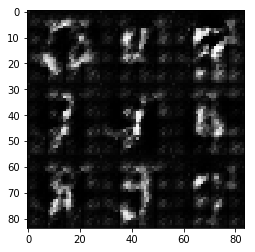

Epoch 1/2... Step 410... d_loss: 1.3740... g_loss: 0.5295 Elapsed: 5m5s
Epoch 1/2... Step 420... d_loss: 0.9761... g_loss: 0.9902 Elapsed: 5m5s
Epoch 1/2... Step 430... d_loss: 1.1095... g_loss: 0.9472 Elapsed: 5m5s
Epoch 1/2... Step 440... d_loss: 1.3097... g_loss: 0.5368 Elapsed: 5m5s
Epoch 1/2... Step 450... d_loss: 1.1990... g_loss: 1.8098 Elapsed: 5m5s
Epoch 1/2... Step 460... d_loss: 0.9315... g_loss: 1.1025 Elapsed: 6m6s
Epoch 1/2... Step 470... d_loss: 1.3842... g_loss: 0.6376 Elapsed: 6m6s
Epoch 1/2... Step 480... d_loss: 1.2048... g_loss: 0.7468 Elapsed: 6m6s
Epoch 1/2... Step 490... d_loss: 1.0445... g_loss: 1.4301 Elapsed: 6m6s
Epoch 1/2... Step 500... d_loss: 1.0416... g_loss: 1.1766 Elapsed: 6m6s
Sample output


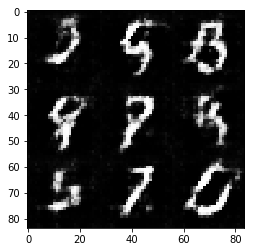

Epoch 1/2... Step 510... d_loss: 1.1707... g_loss: 1.2191 Elapsed: 6m6s
Epoch 1/2... Step 520... d_loss: 0.9647... g_loss: 0.9801 Elapsed: 6m6s
Epoch 1/2... Step 530... d_loss: 0.8838... g_loss: 1.0298 Elapsed: 6m6s
Epoch 1/2... Step 540... d_loss: 1.7752... g_loss: 0.3184 Elapsed: 7m7s
Epoch 1/2... Step 550... d_loss: 1.2008... g_loss: 0.7208 Elapsed: 7m7s
Epoch 1/2... Step 560... d_loss: 1.0933... g_loss: 0.8281 Elapsed: 7m7s
Epoch 1/2... Step 570... d_loss: 0.8539... g_loss: 1.2530 Elapsed: 7m7s
Epoch 1/2... Step 580... d_loss: 1.2006... g_loss: 0.8106 Elapsed: 7m7s
Epoch 1/2... Step 590... d_loss: 1.2459... g_loss: 0.6425 Elapsed: 7m7s
Epoch 1/2... Step 600... d_loss: 1.1076... g_loss: 0.8088 Elapsed: 7m7s
Sample output


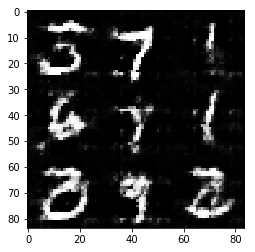

Epoch 1/2... Step 610... d_loss: 1.2877... g_loss: 0.8110 Elapsed: 7m7s
Epoch 1/2... Step 620... d_loss: 1.3663... g_loss: 0.5333 Elapsed: 8m8s
Epoch 1/2... Step 630... d_loss: 1.1619... g_loss: 0.7298 Elapsed: 8m8s
Epoch 1/2... Step 640... d_loss: 0.9128... g_loss: 1.1314 Elapsed: 8m8s
Epoch 1/2... Step 650... d_loss: 1.0532... g_loss: 1.1143 Elapsed: 8m8s
Epoch 1/2... Step 660... d_loss: 1.0978... g_loss: 0.7836 Elapsed: 8m8s
Epoch 1/2... Step 670... d_loss: 1.1703... g_loss: 1.3633 Elapsed: 8m8s
Epoch 1/2... Step 680... d_loss: 1.0221... g_loss: 0.8735 Elapsed: 8m8s
Epoch 1/2... Step 690... d_loss: 1.2065... g_loss: 0.7972 Elapsed: 8m8s
Epoch 1/2... Step 700... d_loss: 0.8976... g_loss: 1.0609 Elapsed: 9m9s
Sample output


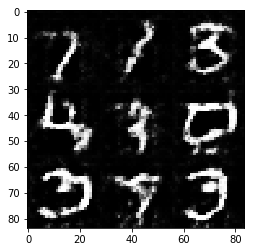

Epoch 1/2... Step 710... d_loss: 1.4659... g_loss: 0.4542 Elapsed: 9m9s
Epoch 1/2... Step 720... d_loss: 1.1355... g_loss: 1.0204 Elapsed: 9m9s
Epoch 1/2... Step 730... d_loss: 1.1937... g_loss: 0.6694 Elapsed: 9m9s
Epoch 1/2... Step 740... d_loss: 1.0184... g_loss: 1.1016 Elapsed: 9m9s
Epoch 1/2... Step 750... d_loss: 1.0976... g_loss: 1.1935 Elapsed: 9m9s
Epoch 1/2... Step 760... d_loss: 0.7888... g_loss: 1.5024 Elapsed: 9m9s
Epoch 1/2... Step 770... d_loss: 0.8695... g_loss: 1.1831 Elapsed: 10m10s
Epoch 1/2... Step 780... d_loss: 1.6554... g_loss: 2.0292 Elapsed: 10m10s
Epoch 1/2... Step 790... d_loss: 0.8960... g_loss: 1.0871 Elapsed: 10m10s
Epoch 1/2... Step 800... d_loss: 1.8950... g_loss: 0.3517 Elapsed: 10m10s
Sample output


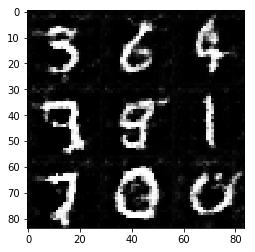

Epoch 1/2... Step 810... d_loss: 0.8026... g_loss: 1.2019 Elapsed: 10m10s
Epoch 1/2... Step 820... d_loss: 1.4199... g_loss: 0.5989 Elapsed: 10m10s
Epoch 1/2... Step 830... d_loss: 0.8865... g_loss: 1.2980 Elapsed: 10m10s
Epoch 1/2... Step 840... d_loss: 0.9519... g_loss: 1.2611 Elapsed: 10m10s
Epoch 1/2... Step 850... d_loss: 0.9946... g_loss: 1.2171 Elapsed: 11m11s
Epoch 1/2... Step 860... d_loss: 1.0843... g_loss: 0.8533 Elapsed: 11m11s
Epoch 1/2... Step 870... d_loss: 1.3580... g_loss: 0.5110 Elapsed: 11m11s
Epoch 1/2... Step 880... d_loss: 1.3338... g_loss: 0.5416 Elapsed: 11m11s
Epoch 1/2... Step 890... d_loss: 1.1685... g_loss: 0.7257 Elapsed: 11m11s
Epoch 1/2... Step 900... d_loss: 1.0446... g_loss: 0.8080 Elapsed: 11m11s
Sample output


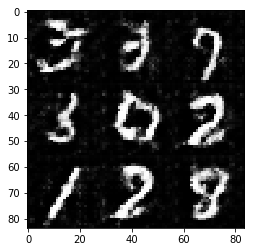

Epoch 1/2... Step 910... d_loss: 1.0934... g_loss: 0.7671 Elapsed: 11m11s
Epoch 1/2... Step 920... d_loss: 1.1301... g_loss: 0.8327 Elapsed: 11m11s
Epoch 1/2... Step 930... d_loss: 1.1354... g_loss: 0.9227 Elapsed: 12m12s
Epoch 1/2... Step 940... d_loss: 1.3269... g_loss: 0.5755 Elapsed: 12m12s
Epoch 1/2... Step 950... d_loss: 0.9934... g_loss: 1.3224 Elapsed: 12m12s
Epoch 1/2... Step 960... d_loss: 0.9365... g_loss: 1.3506 Elapsed: 12m12s
Epoch 1/2... Step 970... d_loss: 1.3744... g_loss: 0.6955 Elapsed: 12m12s
Epoch 1/2... Step 980... d_loss: 1.1669... g_loss: 1.4564 Elapsed: 12m12s
Epoch 1/2... Step 990... d_loss: 1.2112... g_loss: 0.8085 Elapsed: 12m12s
Epoch 1/2... Step 1000... d_loss: 0.9911... g_loss: 0.9434 Elapsed: 13m13s
Sample output


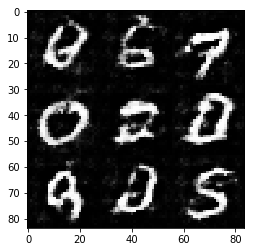

Epoch 1/2... Step 1010... d_loss: 1.2502... g_loss: 0.6627 Elapsed: 13m13s
Epoch 1/2... Step 1020... d_loss: 1.2970... g_loss: 0.6334 Elapsed: 13m13s
Epoch 1/2... Step 1030... d_loss: 1.2084... g_loss: 0.7186 Elapsed: 13m13s
Epoch 1/2... Step 1040... d_loss: 1.0954... g_loss: 0.7521 Elapsed: 13m13s
Epoch 1/2... Step 1050... d_loss: 1.1663... g_loss: 0.6923 Elapsed: 13m13s
Epoch 1/2... Step 1060... d_loss: 1.0085... g_loss: 1.0334 Elapsed: 13m13s
Epoch 1/2... Step 1070... d_loss: 1.2803... g_loss: 0.7517 Elapsed: 13m13s
Epoch 1/2... Step 1080... d_loss: 1.1950... g_loss: 0.6597 Elapsed: 14m14s
Epoch 1/2... Step 1090... d_loss: 1.1475... g_loss: 0.7074 Elapsed: 14m14s
Epoch 1/2... Step 1100... d_loss: 1.3110... g_loss: 0.6185 Elapsed: 14m14s
Sample output


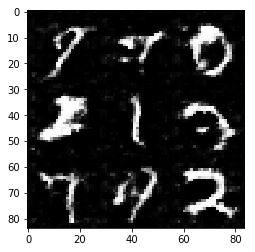

Epoch 1/2... Step 1110... d_loss: 1.2976... g_loss: 0.5706 Elapsed: 14m14s
Epoch 1/2... Step 1120... d_loss: 1.0410... g_loss: 1.1330 Elapsed: 14m14s
Epoch 1/2... Step 1130... d_loss: 0.9113... g_loss: 1.1381 Elapsed: 14m14s
Epoch 1/2... Step 1140... d_loss: 1.2855... g_loss: 0.9920 Elapsed: 14m14s
Epoch 1/2... Step 1150... d_loss: 1.0112... g_loss: 1.1332 Elapsed: 14m14s
Epoch 1/2... Step 1160... d_loss: 1.1281... g_loss: 0.8951 Elapsed: 15m15s
Epoch 1/2... Step 1170... d_loss: 1.1357... g_loss: 0.7282 Elapsed: 15m15s
Epoch 1/2... Step 1180... d_loss: 1.1176... g_loss: 0.7549 Elapsed: 15m15s
Epoch 1/2... Step 1190... d_loss: 0.9462... g_loss: 1.0958 Elapsed: 15m15s
Epoch 1/2... Step 1200... d_loss: 0.9682... g_loss: 0.8516 Elapsed: 15m15s
Sample output


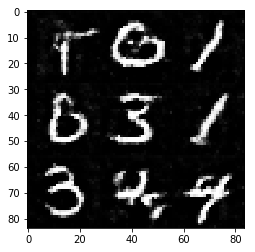

Epoch 1/2... Step 1210... d_loss: 0.9549... g_loss: 1.2186 Elapsed: 15m15s
Epoch 1/2... Step 1220... d_loss: 1.0963... g_loss: 0.9557 Elapsed: 15m15s
Epoch 1/2... Step 1230... d_loss: 1.2811... g_loss: 0.6607 Elapsed: 16m16s
Epoch 1/2... Step 1240... d_loss: 1.0024... g_loss: 1.0562 Elapsed: 16m16s
Epoch 1/2... Step 1250... d_loss: 1.0377... g_loss: 1.3041 Elapsed: 16m16s
Epoch 1/2... Step 1260... d_loss: 0.8690... g_loss: 1.0740 Elapsed: 16m16s
Epoch 1/2... Step 1270... d_loss: 1.2303... g_loss: 0.7011 Elapsed: 16m16s
Epoch 1/2... Step 1280... d_loss: 0.9003... g_loss: 1.1875 Elapsed: 16m16s
Epoch 1/2... Step 1290... d_loss: 1.0782... g_loss: 0.8239 Elapsed: 16m16s
Epoch 1/2... Step 1300... d_loss: 1.0116... g_loss: 0.9329 Elapsed: 16m16s
Sample output


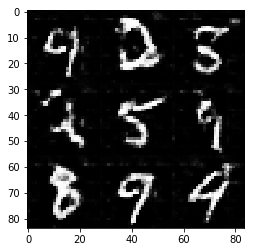

Epoch 1/2... Step 1310... d_loss: 1.0922... g_loss: 1.1999 Elapsed: 17m17s
Epoch 1/2... Step 1320... d_loss: 1.0283... g_loss: 1.0095 Elapsed: 17m17s
Epoch 1/2... Step 1330... d_loss: 1.0878... g_loss: 0.9380 Elapsed: 17m17s
Epoch 1/2... Step 1340... d_loss: 0.9631... g_loss: 1.2011 Elapsed: 17m17s
Epoch 1/2... Step 1350... d_loss: 1.1650... g_loss: 0.7363 Elapsed: 17m17s
Epoch 1/2... Step 1360... d_loss: 1.2090... g_loss: 0.7264 Elapsed: 17m17s
Epoch 1/2... Step 1370... d_loss: 0.9371... g_loss: 1.0391 Elapsed: 17m17s
Epoch 1/2... Step 1380... d_loss: 1.4688... g_loss: 0.5613 Elapsed: 17m17s
Epoch 1/2... Step 1390... d_loss: 0.7701... g_loss: 1.2586 Elapsed: 18m18s
Epoch 1/2... Step 1400... d_loss: 1.3673... g_loss: 0.6473 Elapsed: 18m18s
Sample output


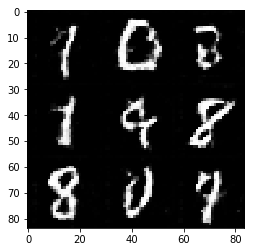

Epoch 1/2... Step 1410... d_loss: 1.3434... g_loss: 0.6611 Elapsed: 18m18s
Epoch 1/2... Step 1420... d_loss: 1.2561... g_loss: 0.6641 Elapsed: 18m18s
Epoch 1/2... Step 1430... d_loss: 1.2233... g_loss: 0.7086 Elapsed: 18m18s
Epoch 1/2... Step 1440... d_loss: 1.0183... g_loss: 0.9655 Elapsed: 18m18s
Epoch 1/2... Step 1450... d_loss: 0.9799... g_loss: 1.1341 Elapsed: 18m18s
Epoch 1/2... Step 1460... d_loss: 1.1136... g_loss: 1.0800 Elapsed: 19m19s
Epoch 1/2... Step 1470... d_loss: 1.3542... g_loss: 0.5505 Elapsed: 19m19s
Epoch 1/2... Step 1480... d_loss: 1.1141... g_loss: 0.7179 Elapsed: 19m19s
Epoch 1/2... Step 1490... d_loss: 1.3593... g_loss: 0.5885 Elapsed: 19m19s
Epoch 1/2... Step 1500... d_loss: 1.1526... g_loss: 0.8781 Elapsed: 19m19s
Sample output


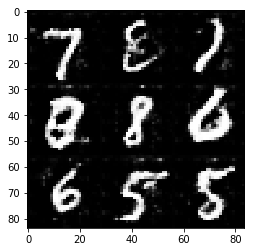

Epoch 1/2... Step 1510... d_loss: 1.1504... g_loss: 0.8466 Elapsed: 19m19s
Epoch 1/2... Step 1520... d_loss: 1.0917... g_loss: 1.0198 Elapsed: 19m19s
Epoch 1/2... Step 1530... d_loss: 1.1111... g_loss: 1.2770 Elapsed: 19m19s
Epoch 1/2... Step 1540... d_loss: 1.0750... g_loss: 1.3262 Elapsed: 20m20s
Epoch 1/2... Step 1550... d_loss: 1.1842... g_loss: 0.6558 Elapsed: 20m20s
Epoch 1/2... Step 1560... d_loss: 1.0832... g_loss: 0.9790 Elapsed: 20m20s
Epoch 1/2... Step 1570... d_loss: 1.0583... g_loss: 0.7883 Elapsed: 20m20s
Epoch 1/2... Step 1580... d_loss: 1.0806... g_loss: 0.8539 Elapsed: 20m20s
Epoch 1/2... Step 1590... d_loss: 1.2044... g_loss: 0.8345 Elapsed: 20m20s
Epoch 1/2... Step 1600... d_loss: 1.0436... g_loss: 0.8717 Elapsed: 20m20s
Sample output


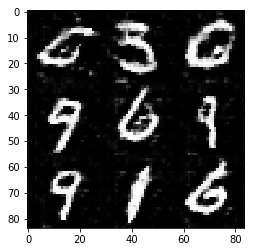

Epoch 1/2... Step 1610... d_loss: 1.1594... g_loss: 0.8411 Elapsed: 20m20s
Epoch 1/2... Step 1620... d_loss: 1.2560... g_loss: 0.6595 Elapsed: 21m21s
Epoch 1/2... Step 1630... d_loss: 1.1495... g_loss: 1.0107 Elapsed: 21m21s
Epoch 1/2... Step 1640... d_loss: 1.2367... g_loss: 0.6448 Elapsed: 21m21s
Epoch 1/2... Step 1650... d_loss: 0.7568... g_loss: 1.4448 Elapsed: 21m21s
Epoch 1/2... Step 1660... d_loss: 1.5420... g_loss: 0.5384 Elapsed: 21m21s
Epoch 1/2... Step 1670... d_loss: 1.0567... g_loss: 0.8378 Elapsed: 21m21s
Epoch 1/2... Step 1680... d_loss: 0.8604... g_loss: 1.4261 Elapsed: 21m21s
Epoch 1/2... Step 1690... d_loss: 1.3301... g_loss: 0.6043 Elapsed: 21m21s
Epoch 1/2... Step 1700... d_loss: 0.9382... g_loss: 1.0033 Elapsed: 22m22s
Sample output


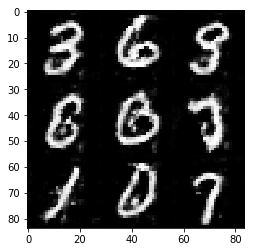

Epoch 1/2... Step 1710... d_loss: 0.9954... g_loss: 0.8874 Elapsed: 22m22s
Epoch 1/2... Step 1720... d_loss: 0.8711... g_loss: 1.5307 Elapsed: 22m22s
Epoch 1/2... Step 1730... d_loss: 1.1696... g_loss: 0.9367 Elapsed: 22m22s
Epoch 1/2... Step 1740... d_loss: 1.1228... g_loss: 1.0022 Elapsed: 22m22s
Epoch 1/2... Step 1750... d_loss: 0.9474... g_loss: 1.1418 Elapsed: 22m22s
Epoch 1/2... Step 1760... d_loss: 0.9871... g_loss: 1.0441 Elapsed: 22m22s
Epoch 1/2... Step 1770... d_loss: 1.0343... g_loss: 0.8275 Elapsed: 23m23s
Epoch 1/2... Step 1780... d_loss: 1.0517... g_loss: 0.8524 Elapsed: 23m23s
Epoch 1/2... Step 1790... d_loss: 0.9715... g_loss: 0.9880 Elapsed: 23m23s
Epoch 1/2... Step 1800... d_loss: 0.8399... g_loss: 1.3565 Elapsed: 23m23s
Sample output


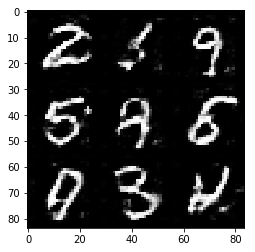

Epoch 1/2... Step 1810... d_loss: 1.2038... g_loss: 0.7429 Elapsed: 23m23s
Epoch 1/2... Step 1820... d_loss: 1.2008... g_loss: 0.8110 Elapsed: 23m23s
Epoch 1/2... Step 1830... d_loss: 1.3534... g_loss: 0.6587 Elapsed: 23m23s
Epoch 1/2... Step 1840... d_loss: 1.4167... g_loss: 0.5028 Elapsed: 23m23s
Epoch 1/2... Step 1850... d_loss: 1.1777... g_loss: 0.8542 Elapsed: 24m24s
Epoch 1/2... Step 1860... d_loss: 1.2977... g_loss: 0.6290 Elapsed: 24m24s
Epoch 1/2... Step 1870... d_loss: 0.9584... g_loss: 1.0774 Elapsed: 24m24s
Epoch 2/2... Step 1880... d_loss: 1.0363... g_loss: 0.7903 Elapsed: 24m24s
Epoch 2/2... Step 1890... d_loss: 1.0340... g_loss: 0.9346 Elapsed: 24m24s
Epoch 2/2... Step 1900... d_loss: 0.9343... g_loss: 1.2619 Elapsed: 24m24s
Sample output


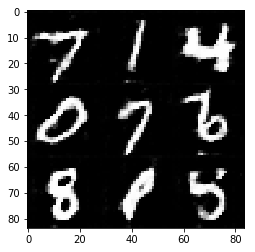

Epoch 2/2... Step 1910... d_loss: 1.0757... g_loss: 1.0143 Elapsed: 24m24s
Epoch 2/2... Step 1920... d_loss: 1.0124... g_loss: 0.9534 Elapsed: 24m24s
Epoch 2/2... Step 1930... d_loss: 1.2743... g_loss: 0.7531 Elapsed: 25m25s
Epoch 2/2... Step 1940... d_loss: 1.1846... g_loss: 0.7574 Elapsed: 25m25s
Epoch 2/2... Step 1950... d_loss: 0.9726... g_loss: 0.9895 Elapsed: 25m25s
Epoch 2/2... Step 1960... d_loss: 0.9691... g_loss: 0.9142 Elapsed: 25m25s
Epoch 2/2... Step 1970... d_loss: 1.4814... g_loss: 0.4846 Elapsed: 25m25s
Epoch 2/2... Step 1980... d_loss: 1.7362... g_loss: 0.3490 Elapsed: 25m25s
Epoch 2/2... Step 1990... d_loss: 1.0816... g_loss: 0.7417 Elapsed: 25m25s
Epoch 2/2... Step 2000... d_loss: 1.1179... g_loss: 0.7577 Elapsed: 25m25s
Sample output


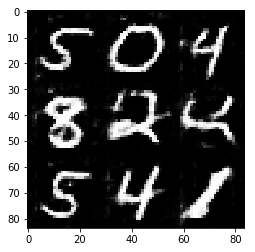

Epoch 2/2... Step 2010... d_loss: 1.2703... g_loss: 0.6653 Elapsed: 26m26s
Epoch 2/2... Step 2020... d_loss: 0.9585... g_loss: 0.9511 Elapsed: 26m26s
Epoch 2/2... Step 2030... d_loss: 0.9613... g_loss: 0.9644 Elapsed: 26m26s
Epoch 2/2... Step 2040... d_loss: 0.8563... g_loss: 1.1886 Elapsed: 26m26s
Epoch 2/2... Step 2050... d_loss: 1.3423... g_loss: 0.6485 Elapsed: 26m26s
Epoch 2/2... Step 2060... d_loss: 1.2191... g_loss: 0.6446 Elapsed: 26m26s
Epoch 2/2... Step 2070... d_loss: 1.1598... g_loss: 0.6989 Elapsed: 26m26s
Epoch 2/2... Step 2080... d_loss: 1.4550... g_loss: 0.4738 Elapsed: 27m27s
Epoch 2/2... Step 2090... d_loss: 1.0662... g_loss: 0.8024 Elapsed: 27m27s
Epoch 2/2... Step 2100... d_loss: 0.9935... g_loss: 1.0597 Elapsed: 27m27s
Sample output


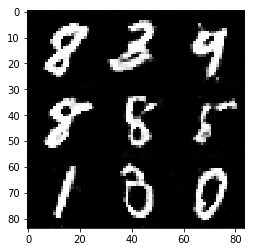

Epoch 2/2... Step 2110... d_loss: 1.1907... g_loss: 0.6570 Elapsed: 27m27s
Epoch 2/2... Step 2120... d_loss: 1.1754... g_loss: 0.7391 Elapsed: 27m27s
Epoch 2/2... Step 2130... d_loss: 1.2428... g_loss: 0.6403 Elapsed: 27m27s
Epoch 2/2... Step 2140... d_loss: 0.9695... g_loss: 1.0971 Elapsed: 27m27s
Epoch 2/2... Step 2150... d_loss: 1.4605... g_loss: 0.4442 Elapsed: 27m27s
Epoch 2/2... Step 2160... d_loss: 0.9180... g_loss: 0.9861 Elapsed: 28m28s
Epoch 2/2... Step 2170... d_loss: 0.9779... g_loss: 1.1379 Elapsed: 28m28s
Epoch 2/2... Step 2180... d_loss: 1.1475... g_loss: 0.6891 Elapsed: 28m28s
Epoch 2/2... Step 2190... d_loss: 1.0218... g_loss: 0.8767 Elapsed: 28m28s
Epoch 2/2... Step 2200... d_loss: 1.1812... g_loss: 0.9133 Elapsed: 28m28s
Sample output


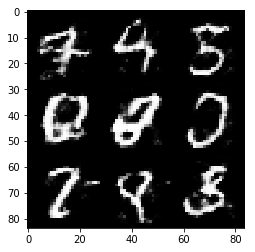

Epoch 2/2... Step 2210... d_loss: 1.1076... g_loss: 0.9564 Elapsed: 28m28s
Epoch 2/2... Step 2220... d_loss: 0.8702... g_loss: 1.1042 Elapsed: 28m28s
Epoch 2/2... Step 2230... d_loss: 1.3556... g_loss: 0.6387 Elapsed: 28m28s
Epoch 2/2... Step 2240... d_loss: 1.2019... g_loss: 0.6673 Elapsed: 29m29s
Epoch 2/2... Step 2250... d_loss: 0.9365... g_loss: 0.9076 Elapsed: 29m29s
Epoch 2/2... Step 2260... d_loss: 1.1413... g_loss: 0.8648 Elapsed: 29m29s
Epoch 2/2... Step 2270... d_loss: 1.0210... g_loss: 1.0714 Elapsed: 29m29s
Epoch 2/2... Step 2280... d_loss: 1.4800... g_loss: 0.4410 Elapsed: 29m29s
Epoch 2/2... Step 2290... d_loss: 1.3561... g_loss: 0.5535 Elapsed: 29m29s
Epoch 2/2... Step 2300... d_loss: 1.2413... g_loss: 1.1670 Elapsed: 29m29s
Sample output


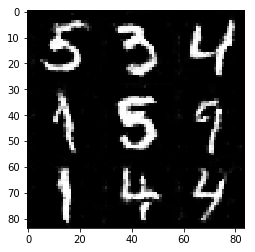

Epoch 2/2... Step 2310... d_loss: 0.8361... g_loss: 1.1628 Elapsed: 30m30s
Epoch 2/2... Step 2320... d_loss: 1.1360... g_loss: 0.7004 Elapsed: 30m30s
Epoch 2/2... Step 2330... d_loss: 1.1355... g_loss: 0.7433 Elapsed: 30m30s
Epoch 2/2... Step 2340... d_loss: 1.1149... g_loss: 0.7722 Elapsed: 30m30s
Epoch 2/2... Step 2350... d_loss: 1.6299... g_loss: 0.3933 Elapsed: 30m30s
Epoch 2/2... Step 2360... d_loss: 1.1195... g_loss: 0.7063 Elapsed: 30m30s
Epoch 2/2... Step 2370... d_loss: 1.1587... g_loss: 1.0722 Elapsed: 30m30s
Epoch 2/2... Step 2380... d_loss: 1.0725... g_loss: 0.8362 Elapsed: 30m30s
Epoch 2/2... Step 2390... d_loss: 1.2385... g_loss: 0.5959 Elapsed: 31m31s
Epoch 2/2... Step 2400... d_loss: 1.2833... g_loss: 0.6048 Elapsed: 31m31s
Sample output


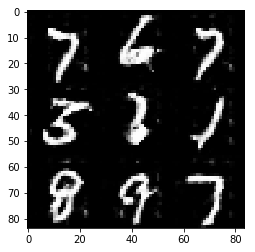

Epoch 2/2... Step 2410... d_loss: 0.9354... g_loss: 1.1593 Elapsed: 31m31s
Epoch 2/2... Step 2420... d_loss: 0.9072... g_loss: 1.0580 Elapsed: 31m31s
Epoch 2/2... Step 2430... d_loss: 1.1712... g_loss: 0.9318 Elapsed: 31m31s
Epoch 2/2... Step 2440... d_loss: 0.9287... g_loss: 1.0467 Elapsed: 31m31s
Epoch 2/2... Step 2450... d_loss: 0.9778... g_loss: 1.0415 Elapsed: 31m31s
Epoch 2/2... Step 2460... d_loss: 1.1898... g_loss: 1.1009 Elapsed: 31m31s
Epoch 2/2... Step 2470... d_loss: 1.1328... g_loss: 0.6943 Elapsed: 32m32s
Epoch 2/2... Step 2480... d_loss: 1.0472... g_loss: 0.8403 Elapsed: 32m32s
Epoch 2/2... Step 2490... d_loss: 1.4784... g_loss: 0.4411 Elapsed: 32m32s
Epoch 2/2... Step 2500... d_loss: 1.1706... g_loss: 0.9189 Elapsed: 32m32s
Sample output


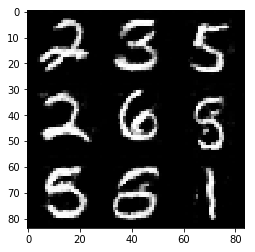

Epoch 2/2... Step 2510... d_loss: 1.2620... g_loss: 0.6727 Elapsed: 32m32s
Epoch 2/2... Step 2520... d_loss: 1.0575... g_loss: 0.9517 Elapsed: 32m32s
Epoch 2/2... Step 2530... d_loss: 0.8901... g_loss: 1.0359 Elapsed: 32m32s
Epoch 2/2... Step 2540... d_loss: 1.5664... g_loss: 0.4122 Elapsed: 33m33s
Epoch 2/2... Step 2550... d_loss: 1.2127... g_loss: 0.6494 Elapsed: 33m33s
Epoch 2/2... Step 2560... d_loss: 1.2881... g_loss: 0.6730 Elapsed: 33m33s
Epoch 2/2... Step 2570... d_loss: 1.2782... g_loss: 0.6852 Elapsed: 33m33s
Epoch 2/2... Step 2580... d_loss: 1.1195... g_loss: 1.0154 Elapsed: 33m33s
Epoch 2/2... Step 2590... d_loss: 1.1405... g_loss: 0.8739 Elapsed: 33m33s
Epoch 2/2... Step 2600... d_loss: 1.1435... g_loss: 1.4087 Elapsed: 33m33s
Sample output


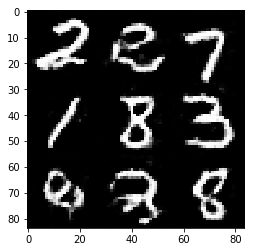

Epoch 2/2... Step 2610... d_loss: 1.1295... g_loss: 0.7835 Elapsed: 33m33s
Epoch 2/2... Step 2620... d_loss: 1.0409... g_loss: 0.8547 Elapsed: 34m34s
Epoch 2/2... Step 2630... d_loss: 1.2310... g_loss: 0.7651 Elapsed: 34m34s
Epoch 2/2... Step 2640... d_loss: 1.6859... g_loss: 0.8795 Elapsed: 34m34s
Epoch 2/2... Step 2650... d_loss: 1.1250... g_loss: 0.7406 Elapsed: 34m34s
Epoch 2/2... Step 2660... d_loss: 1.3948... g_loss: 0.6537 Elapsed: 34m34s
Epoch 2/2... Step 2670... d_loss: 1.1620... g_loss: 0.6988 Elapsed: 34m34s
Epoch 2/2... Step 2680... d_loss: 0.9707... g_loss: 1.0003 Elapsed: 34m34s
Epoch 2/2... Step 2690... d_loss: 1.5376... g_loss: 0.4144 Elapsed: 34m34s
Epoch 2/2... Step 2700... d_loss: 1.5727... g_loss: 0.4728 Elapsed: 35m35s
Sample output


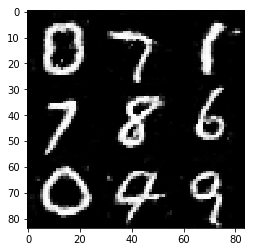

Epoch 2/2... Step 2710... d_loss: 0.9595... g_loss: 0.9074 Elapsed: 35m35s
Epoch 2/2... Step 2720... d_loss: 1.1114... g_loss: 1.1015 Elapsed: 35m35s
Epoch 2/2... Step 2730... d_loss: 1.4249... g_loss: 0.5172 Elapsed: 35m35s
Epoch 2/2... Step 2740... d_loss: 1.1984... g_loss: 0.8365 Elapsed: 35m35s
Epoch 2/2... Step 2750... d_loss: 1.2491... g_loss: 0.5817 Elapsed: 35m35s
Epoch 2/2... Step 2760... d_loss: 1.0391... g_loss: 0.7566 Elapsed: 35m35s
Epoch 2/2... Step 2770... d_loss: 0.9351... g_loss: 1.0370 Elapsed: 35m35s
Epoch 2/2... Step 2780... d_loss: 1.2001... g_loss: 0.7161 Elapsed: 36m36s
Epoch 2/2... Step 2790... d_loss: 1.3526... g_loss: 0.6997 Elapsed: 36m36s
Epoch 2/2... Step 2800... d_loss: 1.2437... g_loss: 0.8038 Elapsed: 36m36s
Sample output


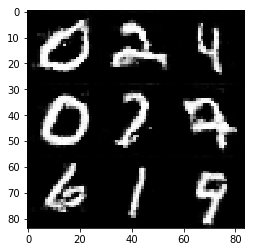

Epoch 2/2... Step 2810... d_loss: 0.8939... g_loss: 1.1019 Elapsed: 36m36s
Epoch 2/2... Step 2820... d_loss: 1.2465... g_loss: 0.6707 Elapsed: 36m36s
Epoch 2/2... Step 2830... d_loss: 0.9887... g_loss: 1.2865 Elapsed: 36m36s
Epoch 2/2... Step 2840... d_loss: 1.0864... g_loss: 0.7825 Elapsed: 36m36s
Epoch 2/2... Step 2850... d_loss: 1.6965... g_loss: 0.3595 Elapsed: 37m37s
Epoch 2/2... Step 2860... d_loss: 1.0842... g_loss: 0.7795 Elapsed: 37m37s
Epoch 2/2... Step 2870... d_loss: 1.2104... g_loss: 0.5864 Elapsed: 37m37s
Epoch 2/2... Step 2880... d_loss: 1.0958... g_loss: 1.3264 Elapsed: 37m37s
Epoch 2/2... Step 2890... d_loss: 0.9778... g_loss: 0.9249 Elapsed: 37m37s
Epoch 2/2... Step 2900... d_loss: 1.1726... g_loss: 0.6351 Elapsed: 37m37s
Sample output


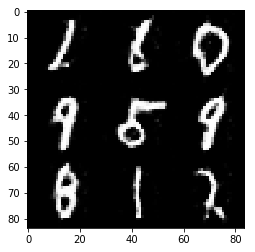

Epoch 2/2... Step 2910... d_loss: 0.7686... g_loss: 1.2580 Elapsed: 37m37s
Epoch 2/2... Step 2920... d_loss: 1.2194... g_loss: 0.6398 Elapsed: 37m37s
Epoch 2/2... Step 2930... d_loss: 0.9205... g_loss: 0.9815 Elapsed: 38m38s
Epoch 2/2... Step 2940... d_loss: 1.2516... g_loss: 0.6264 Elapsed: 38m38s
Epoch 2/2... Step 2950... d_loss: 0.9148... g_loss: 0.9735 Elapsed: 38m38s
Epoch 2/2... Step 2960... d_loss: 1.1199... g_loss: 0.7884 Elapsed: 38m38s
Epoch 2/2... Step 2970... d_loss: 1.2089... g_loss: 0.6499 Elapsed: 38m38s
Epoch 2/2... Step 2980... d_loss: 1.3421... g_loss: 0.5285 Elapsed: 38m38s
Epoch 2/2... Step 2990... d_loss: 1.0222... g_loss: 0.9528 Elapsed: 38m38s
Epoch 2/2... Step 3000... d_loss: 1.2249... g_loss: 0.6898 Elapsed: 38m38s
Sample output


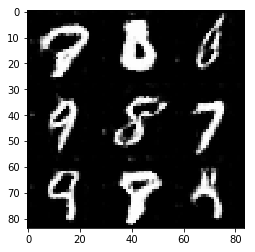

Epoch 2/2... Step 3010... d_loss: 1.3421... g_loss: 0.5428 Elapsed: 39m39s
Epoch 2/2... Step 3020... d_loss: 1.0512... g_loss: 0.7535 Elapsed: 39m39s
Epoch 2/2... Step 3030... d_loss: 0.8152... g_loss: 1.1275 Elapsed: 39m39s
Epoch 2/2... Step 3040... d_loss: 1.1433... g_loss: 0.7129 Elapsed: 39m39s
Epoch 2/2... Step 3050... d_loss: 1.0605... g_loss: 0.7386 Elapsed: 39m39s
Epoch 2/2... Step 3060... d_loss: 0.7129... g_loss: 1.4541 Elapsed: 39m39s
Epoch 2/2... Step 3070... d_loss: 1.0746... g_loss: 0.7856 Elapsed: 39m39s
Epoch 2/2... Step 3080... d_loss: 0.9493... g_loss: 0.9737 Elapsed: 40m40s
Epoch 2/2... Step 3090... d_loss: 1.3129... g_loss: 0.6663 Elapsed: 40m40s
Epoch 2/2... Step 3100... d_loss: 0.7726... g_loss: 1.2477 Elapsed: 40m40s
Sample output


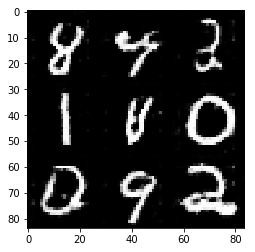

Epoch 2/2... Step 3110... d_loss: 1.2864... g_loss: 0.6790 Elapsed: 40m40s
Epoch 2/2... Step 3120... d_loss: 0.9047... g_loss: 1.1618 Elapsed: 40m40s
Epoch 2/2... Step 3130... d_loss: 1.1751... g_loss: 0.6635 Elapsed: 40m40s
Epoch 2/2... Step 3140... d_loss: 1.2050... g_loss: 0.6200 Elapsed: 40m40s
Epoch 2/2... Step 3150... d_loss: 0.8536... g_loss: 1.1291 Elapsed: 40m40s
Epoch 2/2... Step 3160... d_loss: 0.8421... g_loss: 1.0681 Elapsed: 41m41s
Epoch 2/2... Step 3170... d_loss: 1.5340... g_loss: 0.4172 Elapsed: 41m41s
Epoch 2/2... Step 3180... d_loss: 1.3534... g_loss: 0.5853 Elapsed: 41m41s
Epoch 2/2... Step 3190... d_loss: 0.9905... g_loss: 1.4424 Elapsed: 41m41s
Epoch 2/2... Step 3200... d_loss: 0.8811... g_loss: 1.3409 Elapsed: 41m41s
Sample output


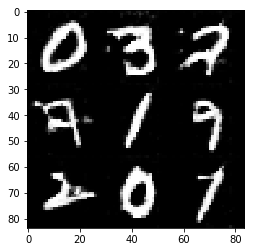

Epoch 2/2... Step 3210... d_loss: 1.1581... g_loss: 0.8005 Elapsed: 41m41s
Epoch 2/2... Step 3220... d_loss: 1.6345... g_loss: 0.3837 Elapsed: 41m41s
Epoch 2/2... Step 3230... d_loss: 1.2266... g_loss: 0.6372 Elapsed: 41m41s
Epoch 2/2... Step 3240... d_loss: 1.1355... g_loss: 1.1079 Elapsed: 42m42s
Epoch 2/2... Step 3250... d_loss: 0.8850... g_loss: 0.9946 Elapsed: 42m42s
Epoch 2/2... Step 3260... d_loss: 1.0880... g_loss: 0.8760 Elapsed: 42m42s
Epoch 2/2... Step 3270... d_loss: 1.3899... g_loss: 0.9577 Elapsed: 42m42s
Epoch 2/2... Step 3280... d_loss: 1.3948... g_loss: 0.6012 Elapsed: 42m42s
Epoch 2/2... Step 3290... d_loss: 1.1430... g_loss: 0.7301 Elapsed: 42m42s
Epoch 2/2... Step 3300... d_loss: 1.4266... g_loss: 0.4968 Elapsed: 42m42s
Sample output


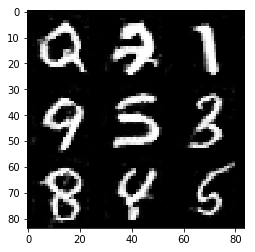

Epoch 2/2... Step 3310... d_loss: 0.9989... g_loss: 1.5841 Elapsed: 43m43s
Epoch 2/2... Step 3320... d_loss: 1.1357... g_loss: 0.7314 Elapsed: 43m43s
Epoch 2/2... Step 3330... d_loss: 1.1823... g_loss: 0.6493 Elapsed: 43m43s
Epoch 2/2... Step 3340... d_loss: 0.9018... g_loss: 1.0741 Elapsed: 43m43s
Epoch 2/2... Step 3350... d_loss: 1.2430... g_loss: 1.1441 Elapsed: 43m43s
Epoch 2/2... Step 3360... d_loss: 0.9759... g_loss: 1.1817 Elapsed: 43m43s
Epoch 2/2... Step 3370... d_loss: 1.1205... g_loss: 0.7633 Elapsed: 43m43s
Epoch 2/2... Step 3380... d_loss: 1.5916... g_loss: 0.3796 Elapsed: 43m43s
Epoch 2/2... Step 3390... d_loss: 0.9144... g_loss: 1.2517 Elapsed: 44m44s
Epoch 2/2... Step 3400... d_loss: 1.1279... g_loss: 0.7057 Elapsed: 44m44s
Sample output


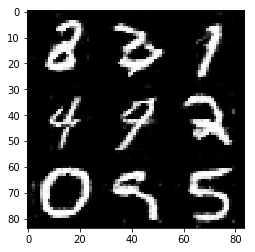

Epoch 2/2... Step 3410... d_loss: 1.2419... g_loss: 0.7391 Elapsed: 44m44s
Epoch 2/2... Step 3420... d_loss: 0.9576... g_loss: 0.8964 Elapsed: 44m44s
Epoch 2/2... Step 3430... d_loss: 1.2220... g_loss: 0.6323 Elapsed: 44m44s
Epoch 2/2... Step 3440... d_loss: 1.0586... g_loss: 0.7391 Elapsed: 44m44s
Epoch 2/2... Step 3450... d_loss: 1.6228... g_loss: 0.3961 Elapsed: 44m44s
Epoch 2/2... Step 3460... d_loss: 1.4851... g_loss: 0.4478 Elapsed: 44m44s
Epoch 2/2... Step 3470... d_loss: 0.9368... g_loss: 1.1666 Elapsed: 45m45s
Epoch 2/2... Step 3480... d_loss: 0.9863... g_loss: 1.0112 Elapsed: 45m45s
Epoch 2/2... Step 3490... d_loss: 0.9472... g_loss: 0.9589 Elapsed: 45m45s
Epoch 2/2... Step 3500... d_loss: 0.9782... g_loss: 1.5360 Elapsed: 45m45s
Sample output


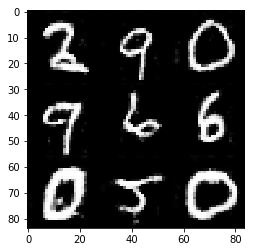

Epoch 2/2... Step 3510... d_loss: 1.3451... g_loss: 0.5609 Elapsed: 45m45s
Epoch 2/2... Step 3520... d_loss: 0.8505... g_loss: 1.2784 Elapsed: 45m45s
Epoch 2/2... Step 3530... d_loss: 1.5202... g_loss: 0.4284 Elapsed: 45m45s
Epoch 2/2... Step 3540... d_loss: 0.8736... g_loss: 0.9547 Elapsed: 46m46s
Epoch 2/2... Step 3550... d_loss: 1.5391... g_loss: 0.4167 Elapsed: 46m46s
Epoch 2/2... Step 3560... d_loss: 1.0970... g_loss: 0.7529 Elapsed: 46m46s
Epoch 2/2... Step 3570... d_loss: 1.1508... g_loss: 0.7161 Elapsed: 46m46s
Epoch 2/2... Step 3580... d_loss: 0.9083... g_loss: 0.9801 Elapsed: 46m46s
Epoch 2/2... Step 3590... d_loss: 1.3896... g_loss: 0.5969 Elapsed: 46m46s
Epoch 2/2... Step 3600... d_loss: 1.2885... g_loss: 0.8909 Elapsed: 46m46s
Sample output


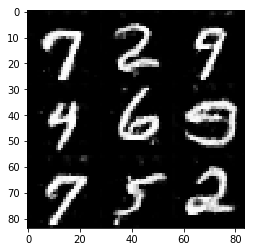

Epoch 2/2... Step 3610... d_loss: 1.0343... g_loss: 0.8574 Elapsed: 47m47s
Epoch 2/2... Step 3620... d_loss: 1.0850... g_loss: 0.9733 Elapsed: 47m47s
Epoch 2/2... Step 3630... d_loss: 1.2373... g_loss: 0.6637 Elapsed: 47m47s
Epoch 2/2... Step 3640... d_loss: 1.1125... g_loss: 0.7259 Elapsed: 47m47s
Epoch 2/2... Step 3650... d_loss: 1.1873... g_loss: 0.6599 Elapsed: 47m47s
Epoch 2/2... Step 3660... d_loss: 0.9225... g_loss: 1.1196 Elapsed: 47m47s
Epoch 2/2... Step 3670... d_loss: 1.2056... g_loss: 0.6871 Elapsed: 47m47s
Epoch 2/2... Step 3680... d_loss: 1.1947... g_loss: 0.7146 Elapsed: 47m47s
Epoch 2/2... Step 3690... d_loss: 1.0764... g_loss: 0.8577 Elapsed: 48m48s
Epoch 2/2... Step 3700... d_loss: 1.3630... g_loss: 0.5810 Elapsed: 48m48s
Sample output


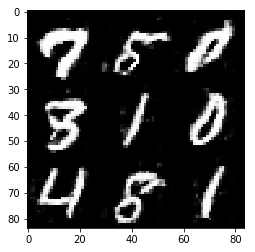

Epoch 2/2... Step 3710... d_loss: 0.9682... g_loss: 1.2305 Elapsed: 48m48s
Epoch 2/2... Step 3720... d_loss: 0.9812... g_loss: 0.9187 Elapsed: 48m48s
Epoch 2/2... Step 3730... d_loss: 0.9328... g_loss: 0.9638 Elapsed: 48m48s
Epoch 2/2... Step 3740... d_loss: 1.0251... g_loss: 1.0131 Elapsed: 48m48s
Epoch 2/2... Step 3750... d_loss: 1.2982... g_loss: 0.5243 Elapsed: 48m48s
Training done


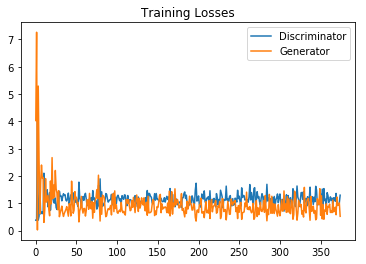

In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Parameters:
epoch_count: 1
batch_size: 32
z_dim: 100
learning_rate: 0.0002
beta1: 0.5
data_shape: (202599, 28, 28, 3)
Getting model inputs... Ok
Calculating model loss... Ok
Getting model optimizers ... Ok
Starting training
Epoch 1/1... Step 10... d_loss: 0.3758... g_loss: 11.1723 Elapsed: 0m0s
Epoch 1/1... Step 20... d_loss: 0.4719... g_loss: 7.8917 Elapsed: 0m0s
Epoch 1/1... Step 30... d_loss: 0.5039... g_loss: 6.2201 Elapsed: 0m0s
Epoch 1/1... Step 40... d_loss: 2.2238... g_loss: 0.2054 Elapsed: 0m0s
Epoch 1/1... Step 50... d_loss: 0.3773... g_loss: 5.7398 Elapsed: 0m0s
Epoch 1/1... Step 60... d_loss: 2.8888... g_loss: 0.0949 Elapsed: 0m0s
Epoch 1/1... Step 70... d_loss: 1.4770... g_loss: 0.6095 Elapsed: 0m0s
Epoch 1/1... Step 80... d_loss: 2.1615... g_loss: 0.2600 Elapsed: 1m1s
Epoch 1/1... Step 90... d_loss: 1.7931... g_loss: 0.5424 Elapsed: 1m1s
Epoch 1/1... Step 100... d_loss: 1.4947... g_loss: 0.7079 Elapsed: 1m1s
Sample output


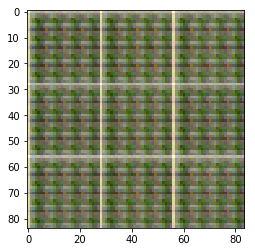

Epoch 1/1... Step 110... d_loss: 1.2254... g_loss: 1.1125 Elapsed: 1m1s
Epoch 1/1... Step 120... d_loss: 1.3128... g_loss: 0.7414 Elapsed: 1m1s
Epoch 1/1... Step 130... d_loss: 1.5569... g_loss: 0.5800 Elapsed: 1m1s
Epoch 1/1... Step 140... d_loss: 1.3422... g_loss: 0.7855 Elapsed: 1m1s
Epoch 1/1... Step 150... d_loss: 1.2913... g_loss: 1.0038 Elapsed: 2m2s
Epoch 1/1... Step 160... d_loss: 1.1475... g_loss: 0.9353 Elapsed: 2m2s
Epoch 1/1... Step 170... d_loss: 1.5726... g_loss: 0.7152 Elapsed: 2m2s
Epoch 1/1... Step 180... d_loss: 1.6870... g_loss: 0.6214 Elapsed: 2m2s
Epoch 1/1... Step 190... d_loss: 1.1487... g_loss: 1.3013 Elapsed: 2m2s
Epoch 1/1... Step 200... d_loss: 1.3266... g_loss: 0.8212 Elapsed: 2m2s
Sample output


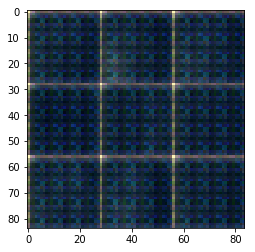

Epoch 1/1... Step 210... d_loss: 1.4017... g_loss: 0.9618 Elapsed: 2m2s
Epoch 1/1... Step 220... d_loss: 1.3209... g_loss: 0.7027 Elapsed: 3m3s
Epoch 1/1... Step 230... d_loss: 1.4325... g_loss: 0.8010 Elapsed: 3m3s
Epoch 1/1... Step 240... d_loss: 1.4332... g_loss: 0.7064 Elapsed: 3m3s
Epoch 1/1... Step 250... d_loss: 1.2510... g_loss: 0.9429 Elapsed: 3m3s
Epoch 1/1... Step 260... d_loss: 1.3850... g_loss: 0.7568 Elapsed: 3m3s
Epoch 1/1... Step 270... d_loss: 1.4421... g_loss: 0.6944 Elapsed: 3m3s
Epoch 1/1... Step 280... d_loss: 1.2438... g_loss: 0.8664 Elapsed: 3m3s
Epoch 1/1... Step 290... d_loss: 1.5053... g_loss: 0.7144 Elapsed: 3m3s
Epoch 1/1... Step 300... d_loss: 1.2194... g_loss: 0.7784 Elapsed: 4m4s
Sample output


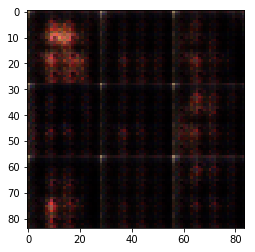

Epoch 1/1... Step 310... d_loss: 1.5075... g_loss: 0.5958 Elapsed: 4m4s
Epoch 1/1... Step 320... d_loss: 1.3463... g_loss: 0.7715 Elapsed: 4m4s
Epoch 1/1... Step 330... d_loss: 1.5295... g_loss: 0.6789 Elapsed: 4m4s
Epoch 1/1... Step 340... d_loss: 1.3640... g_loss: 0.9070 Elapsed: 4m4s
Epoch 1/1... Step 350... d_loss: 1.2902... g_loss: 0.7068 Elapsed: 4m4s
Epoch 1/1... Step 360... d_loss: 1.4484... g_loss: 0.5156 Elapsed: 4m4s
Epoch 1/1... Step 370... d_loss: 1.3541... g_loss: 1.0635 Elapsed: 5m5s
Epoch 1/1... Step 380... d_loss: 1.6191... g_loss: 0.4932 Elapsed: 5m5s
Epoch 1/1... Step 390... d_loss: 1.2696... g_loss: 0.8642 Elapsed: 5m5s
Epoch 1/1... Step 400... d_loss: 1.1882... g_loss: 0.9230 Elapsed: 5m5s
Sample output


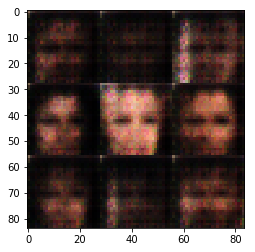

Epoch 1/1... Step 410... d_loss: 1.3542... g_loss: 0.8436 Elapsed: 5m5s
Epoch 1/1... Step 420... d_loss: 1.5588... g_loss: 0.6815 Elapsed: 5m5s
Epoch 1/1... Step 430... d_loss: 1.3436... g_loss: 0.6969 Elapsed: 5m5s
Epoch 1/1... Step 440... d_loss: 1.0539... g_loss: 1.0451 Elapsed: 5m5s
Epoch 1/1... Step 450... d_loss: 1.3817... g_loss: 0.8716 Elapsed: 6m6s
Epoch 1/1... Step 460... d_loss: 1.3296... g_loss: 0.7556 Elapsed: 6m6s
Epoch 1/1... Step 470... d_loss: 1.3657... g_loss: 0.7239 Elapsed: 6m6s
Epoch 1/1... Step 480... d_loss: 1.4334... g_loss: 0.8117 Elapsed: 6m6s
Epoch 1/1... Step 490... d_loss: 1.3064... g_loss: 0.8492 Elapsed: 6m6s
Epoch 1/1... Step 500... d_loss: 1.2739... g_loss: 0.8918 Elapsed: 6m6s
Sample output


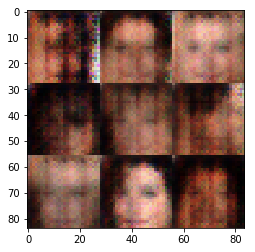

Epoch 1/1... Step 510... d_loss: 1.0826... g_loss: 0.9473 Elapsed: 6m6s
Epoch 1/1... Step 520... d_loss: 1.3129... g_loss: 0.6929 Elapsed: 7m7s
Epoch 1/1... Step 530... d_loss: 1.2552... g_loss: 0.8021 Elapsed: 7m7s
Epoch 1/1... Step 540... d_loss: 1.1573... g_loss: 0.9778 Elapsed: 7m7s
Epoch 1/1... Step 550... d_loss: 1.1696... g_loss: 0.9185 Elapsed: 7m7s
Epoch 1/1... Step 560... d_loss: 1.5065... g_loss: 0.8768 Elapsed: 7m7s
Epoch 1/1... Step 570... d_loss: 1.2804... g_loss: 0.8250 Elapsed: 7m7s
Epoch 1/1... Step 580... d_loss: 1.2827... g_loss: 0.7742 Elapsed: 7m7s
Epoch 1/1... Step 590... d_loss: 1.2971... g_loss: 0.9422 Elapsed: 7m7s
Epoch 1/1... Step 600... d_loss: 1.3574... g_loss: 0.6951 Elapsed: 8m8s
Sample output


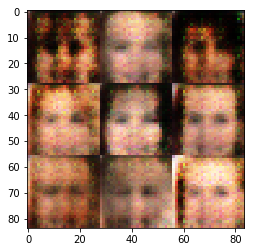

Epoch 1/1... Step 610... d_loss: 1.3364... g_loss: 0.8242 Elapsed: 8m8s
Epoch 1/1... Step 620... d_loss: 1.2838... g_loss: 0.8181 Elapsed: 8m8s
Epoch 1/1... Step 630... d_loss: 1.2409... g_loss: 0.9014 Elapsed: 8m8s
Epoch 1/1... Step 640... d_loss: 1.4005... g_loss: 0.7701 Elapsed: 8m8s
Epoch 1/1... Step 650... d_loss: 1.2103... g_loss: 0.9473 Elapsed: 8m8s
Epoch 1/1... Step 660... d_loss: 1.2910... g_loss: 0.7996 Elapsed: 8m8s
Epoch 1/1... Step 670... d_loss: 1.3154... g_loss: 0.8991 Elapsed: 9m9s
Epoch 1/1... Step 680... d_loss: 1.5611... g_loss: 0.6264 Elapsed: 9m9s
Epoch 1/1... Step 690... d_loss: 1.3991... g_loss: 0.7489 Elapsed: 9m9s
Epoch 1/1... Step 700... d_loss: 1.2820... g_loss: 0.9189 Elapsed: 9m9s
Sample output


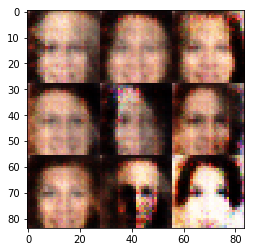

Epoch 1/1... Step 710... d_loss: 1.2789... g_loss: 1.0035 Elapsed: 9m9s
Epoch 1/1... Step 720... d_loss: 1.3649... g_loss: 0.9802 Elapsed: 9m9s
Epoch 1/1... Step 730... d_loss: 1.3720... g_loss: 0.8337 Elapsed: 9m9s
Epoch 1/1... Step 740... d_loss: 1.3085... g_loss: 0.8158 Elapsed: 10m10s
Epoch 1/1... Step 750... d_loss: 1.1711... g_loss: 1.1352 Elapsed: 10m10s
Epoch 1/1... Step 760... d_loss: 1.2819... g_loss: 0.8430 Elapsed: 10m10s
Epoch 1/1... Step 770... d_loss: 1.4463... g_loss: 0.7143 Elapsed: 10m10s
Epoch 1/1... Step 780... d_loss: 1.2906... g_loss: 0.8203 Elapsed: 10m10s
Epoch 1/1... Step 790... d_loss: 1.3761... g_loss: 0.9254 Elapsed: 10m10s
Epoch 1/1... Step 800... d_loss: 1.2710... g_loss: 1.0033 Elapsed: 10m10s
Sample output


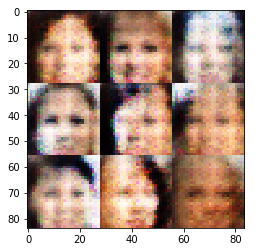

Epoch 1/1... Step 810... d_loss: 1.4455... g_loss: 0.7051 Elapsed: 10m10s
Epoch 1/1... Step 820... d_loss: 1.4555... g_loss: 0.6583 Elapsed: 11m11s
Epoch 1/1... Step 830... d_loss: 1.1715... g_loss: 0.8798 Elapsed: 11m11s
Epoch 1/1... Step 840... d_loss: 1.2809... g_loss: 0.9102 Elapsed: 11m11s
Epoch 1/1... Step 850... d_loss: 1.3096... g_loss: 0.9397 Elapsed: 11m11s
Epoch 1/1... Step 860... d_loss: 1.2323... g_loss: 0.8516 Elapsed: 11m11s
Epoch 1/1... Step 870... d_loss: 1.4270... g_loss: 0.8587 Elapsed: 11m11s
Epoch 1/1... Step 880... d_loss: 1.3706... g_loss: 0.8175 Elapsed: 11m11s
Epoch 1/1... Step 890... d_loss: 1.2524... g_loss: 0.8846 Elapsed: 12m12s
Epoch 1/1... Step 900... d_loss: 1.4311... g_loss: 0.6999 Elapsed: 12m12s
Sample output


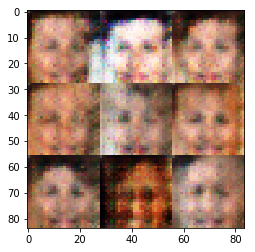

Epoch 1/1... Step 910... d_loss: 1.2782... g_loss: 0.8802 Elapsed: 12m12s
Epoch 1/1... Step 920... d_loss: 1.4003... g_loss: 0.7464 Elapsed: 12m12s
Epoch 1/1... Step 930... d_loss: 1.3715... g_loss: 0.8026 Elapsed: 12m12s
Epoch 1/1... Step 940... d_loss: 1.3604... g_loss: 0.7514 Elapsed: 12m12s
Epoch 1/1... Step 950... d_loss: 1.2215... g_loss: 0.8167 Elapsed: 12m12s
Epoch 1/1... Step 960... d_loss: 1.3719... g_loss: 0.6731 Elapsed: 12m12s
Epoch 1/1... Step 970... d_loss: 1.3609... g_loss: 0.7328 Elapsed: 13m13s
Epoch 1/1... Step 980... d_loss: 1.1960... g_loss: 0.8712 Elapsed: 13m13s
Epoch 1/1... Step 990... d_loss: 1.2781... g_loss: 0.9257 Elapsed: 13m13s
Epoch 1/1... Step 1000... d_loss: 1.3004... g_loss: 0.7441 Elapsed: 13m13s
Sample output


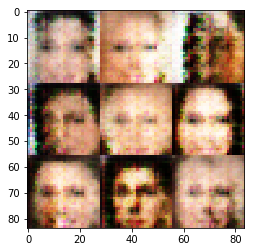

Epoch 1/1... Step 1010... d_loss: 1.2519... g_loss: 0.9193 Elapsed: 13m13s
Epoch 1/1... Step 1020... d_loss: 1.3530... g_loss: 0.7736 Elapsed: 13m13s
Epoch 1/1... Step 1030... d_loss: 1.4574... g_loss: 0.7625 Elapsed: 13m13s
Epoch 1/1... Step 1040... d_loss: 1.2921... g_loss: 0.8090 Elapsed: 14m14s
Epoch 1/1... Step 1050... d_loss: 1.3486... g_loss: 0.8356 Elapsed: 14m14s
Epoch 1/1... Step 1060... d_loss: 1.3555... g_loss: 1.0152 Elapsed: 14m14s
Epoch 1/1... Step 1070... d_loss: 1.1122... g_loss: 0.9105 Elapsed: 14m14s
Epoch 1/1... Step 1080... d_loss: 1.3014... g_loss: 0.8183 Elapsed: 14m14s
Epoch 1/1... Step 1090... d_loss: 1.2882... g_loss: 0.8632 Elapsed: 14m14s
Epoch 1/1... Step 1100... d_loss: 1.1923... g_loss: 0.8650 Elapsed: 14m14s
Sample output


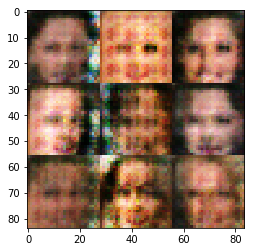

Epoch 1/1... Step 1110... d_loss: 1.4109... g_loss: 0.6926 Elapsed: 15m15s
Epoch 1/1... Step 1120... d_loss: 1.4528... g_loss: 0.6507 Elapsed: 15m15s
Epoch 1/1... Step 1130... d_loss: 1.4100... g_loss: 0.6488 Elapsed: 15m15s
Epoch 1/1... Step 1140... d_loss: 1.3863... g_loss: 0.8187 Elapsed: 15m15s
Epoch 1/1... Step 1150... d_loss: 1.2463... g_loss: 0.7541 Elapsed: 15m15s
Epoch 1/1... Step 1160... d_loss: 1.1787... g_loss: 0.9441 Elapsed: 15m15s
Epoch 1/1... Step 1170... d_loss: 1.3989... g_loss: 0.6006 Elapsed: 15m15s
Epoch 1/1... Step 1180... d_loss: 1.2474... g_loss: 0.7336 Elapsed: 15m15s
Epoch 1/1... Step 1190... d_loss: 1.3042... g_loss: 0.7326 Elapsed: 16m16s
Epoch 1/1... Step 1200... d_loss: 1.3478... g_loss: 0.6625 Elapsed: 16m16s
Sample output


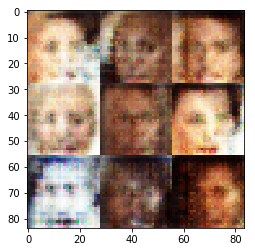

Epoch 1/1... Step 1210... d_loss: 1.3032... g_loss: 0.7639 Elapsed: 16m16s
Epoch 1/1... Step 1220... d_loss: 1.2435... g_loss: 0.9793 Elapsed: 16m16s
Epoch 1/1... Step 1230... d_loss: 1.2678... g_loss: 0.9224 Elapsed: 16m16s
Epoch 1/1... Step 1240... d_loss: 1.2820... g_loss: 0.8679 Elapsed: 16m16s
Epoch 1/1... Step 1250... d_loss: 1.3679... g_loss: 0.6425 Elapsed: 16m16s
Epoch 1/1... Step 1260... d_loss: 1.6638... g_loss: 0.4491 Elapsed: 17m17s
Epoch 1/1... Step 1270... d_loss: 1.4266... g_loss: 0.7605 Elapsed: 17m17s
Epoch 1/1... Step 1280... d_loss: 1.3689... g_loss: 0.8678 Elapsed: 17m17s
Epoch 1/1... Step 1290... d_loss: 1.0753... g_loss: 0.9838 Elapsed: 17m17s
Epoch 1/1... Step 1300... d_loss: 1.2466... g_loss: 0.9314 Elapsed: 17m17s
Sample output


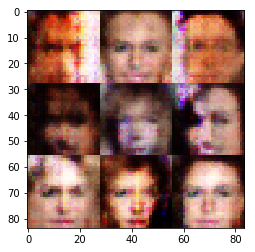

Epoch 1/1... Step 1310... d_loss: 1.2420... g_loss: 0.7691 Elapsed: 17m17s
Epoch 1/1... Step 1320... d_loss: 1.3387... g_loss: 0.9350 Elapsed: 17m17s
Epoch 1/1... Step 1330... d_loss: 0.9851... g_loss: 1.2366 Elapsed: 17m17s
Epoch 1/1... Step 1340... d_loss: 1.3932... g_loss: 0.6961 Elapsed: 18m18s
Epoch 1/1... Step 1350... d_loss: 1.2453... g_loss: 0.8222 Elapsed: 18m18s
Epoch 1/1... Step 1360... d_loss: 1.2027... g_loss: 0.8871 Elapsed: 18m18s
Epoch 1/1... Step 1370... d_loss: 1.2957... g_loss: 1.0960 Elapsed: 18m18s
Epoch 1/1... Step 1380... d_loss: 1.3014... g_loss: 0.6228 Elapsed: 18m18s
Epoch 1/1... Step 1390... d_loss: 1.4640... g_loss: 0.7825 Elapsed: 18m18s
Epoch 1/1... Step 1400... d_loss: 1.2228... g_loss: 0.8822 Elapsed: 18m18s
Sample output


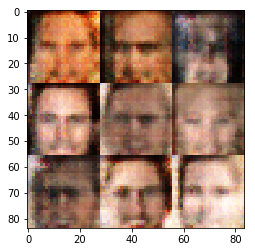

Epoch 1/1... Step 1410... d_loss: 1.1900... g_loss: 0.7459 Elapsed: 19m19s
Epoch 1/1... Step 1420... d_loss: 1.4210... g_loss: 0.9888 Elapsed: 19m19s
Epoch 1/1... Step 1430... d_loss: 1.1430... g_loss: 0.8755 Elapsed: 19m19s
Epoch 1/1... Step 1440... d_loss: 1.3352... g_loss: 0.9274 Elapsed: 19m19s
Epoch 1/1... Step 1450... d_loss: 1.1757... g_loss: 0.8667 Elapsed: 19m19s
Epoch 1/1... Step 1460... d_loss: 1.3995... g_loss: 0.7670 Elapsed: 19m19s
Epoch 1/1... Step 1470... d_loss: 1.0794... g_loss: 0.9113 Elapsed: 19m19s
Epoch 1/1... Step 1480... d_loss: 1.1716... g_loss: 0.9133 Elapsed: 20m20s
Epoch 1/1... Step 1490... d_loss: 1.3006... g_loss: 0.6575 Elapsed: 20m20s
Epoch 1/1... Step 1500... d_loss: 1.2824... g_loss: 0.7657 Elapsed: 20m20s
Sample output


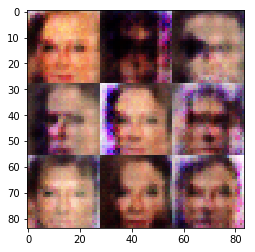

Epoch 1/1... Step 1510... d_loss: 1.6254... g_loss: 0.6110 Elapsed: 20m20s
Epoch 1/1... Step 1520... d_loss: 1.0962... g_loss: 1.0279 Elapsed: 20m20s
Epoch 1/1... Step 1530... d_loss: 1.4185... g_loss: 0.7863 Elapsed: 20m20s
Epoch 1/1... Step 1540... d_loss: 1.1372... g_loss: 0.9442 Elapsed: 20m20s
Epoch 1/1... Step 1550... d_loss: 1.3197... g_loss: 0.8245 Elapsed: 20m20s
Epoch 1/1... Step 1560... d_loss: 1.4278... g_loss: 0.6338 Elapsed: 21m21s
Epoch 1/1... Step 1570... d_loss: 1.2287... g_loss: 0.9713 Elapsed: 21m21s
Epoch 1/1... Step 1580... d_loss: 1.2768... g_loss: 0.8639 Elapsed: 21m21s
Epoch 1/1... Step 1590... d_loss: 1.1687... g_loss: 0.9411 Elapsed: 21m21s
Epoch 1/1... Step 1600... d_loss: 1.3966... g_loss: 0.6944 Elapsed: 21m21s
Sample output


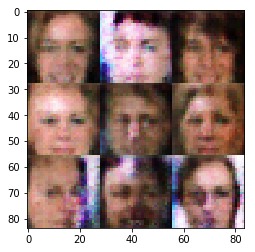

Epoch 1/1... Step 1610... d_loss: 1.2918... g_loss: 0.8694 Elapsed: 21m21s
Epoch 1/1... Step 1620... d_loss: 1.5547... g_loss: 0.4928 Elapsed: 21m21s
Epoch 1/1... Step 1630... d_loss: 1.4629... g_loss: 0.6002 Elapsed: 22m22s
Epoch 1/1... Step 1640... d_loss: 1.4090... g_loss: 0.6696 Elapsed: 22m22s
Epoch 1/1... Step 1650... d_loss: 1.3439... g_loss: 0.6685 Elapsed: 22m22s
Epoch 1/1... Step 1660... d_loss: 1.1315... g_loss: 0.8996 Elapsed: 22m22s
Epoch 1/1... Step 1670... d_loss: 1.2999... g_loss: 0.8128 Elapsed: 22m22s
Epoch 1/1... Step 1680... d_loss: 1.2034... g_loss: 0.9539 Elapsed: 22m22s
Epoch 1/1... Step 1690... d_loss: 1.2733... g_loss: 0.6773 Elapsed: 22m22s
Epoch 1/1... Step 1700... d_loss: 0.9967... g_loss: 1.2885 Elapsed: 22m22s
Sample output


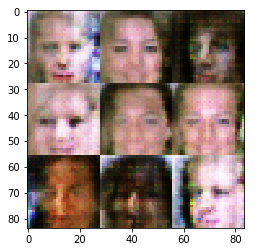

Epoch 1/1... Step 1710... d_loss: 1.3105... g_loss: 0.7295 Elapsed: 23m23s
Epoch 1/1... Step 1720... d_loss: 1.3170... g_loss: 0.7793 Elapsed: 23m23s
Epoch 1/1... Step 1730... d_loss: 1.2216... g_loss: 0.8126 Elapsed: 23m23s
Epoch 1/1... Step 1740... d_loss: 1.2272... g_loss: 0.7499 Elapsed: 23m23s
Epoch 1/1... Step 1750... d_loss: 1.3228... g_loss: 0.6528 Elapsed: 23m23s
Epoch 1/1... Step 1760... d_loss: 1.1286... g_loss: 0.8007 Elapsed: 23m23s
Epoch 1/1... Step 1770... d_loss: 1.4112... g_loss: 0.6411 Elapsed: 23m23s
Epoch 1/1... Step 1780... d_loss: 1.2156... g_loss: 0.8953 Elapsed: 24m24s
Epoch 1/1... Step 1790... d_loss: 1.4076... g_loss: 0.6093 Elapsed: 24m24s
Epoch 1/1... Step 1800... d_loss: 1.1839... g_loss: 1.3577 Elapsed: 24m24s
Sample output


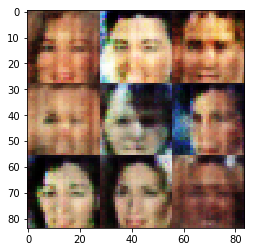

Epoch 1/1... Step 1810... d_loss: 1.2900... g_loss: 0.7757 Elapsed: 24m24s
Epoch 1/1... Step 1820... d_loss: 1.2786... g_loss: 0.9101 Elapsed: 24m24s
Epoch 1/1... Step 1830... d_loss: 1.2302... g_loss: 0.8380 Elapsed: 24m24s
Epoch 1/1... Step 1840... d_loss: 1.2373... g_loss: 0.8399 Elapsed: 24m24s
Epoch 1/1... Step 1850... d_loss: 1.2598... g_loss: 0.8093 Elapsed: 24m24s
Epoch 1/1... Step 1860... d_loss: 1.0974... g_loss: 1.0798 Elapsed: 25m25s
Epoch 1/1... Step 1870... d_loss: 1.2782... g_loss: 0.8461 Elapsed: 25m25s
Epoch 1/1... Step 1880... d_loss: 1.2154... g_loss: 0.9518 Elapsed: 25m25s
Epoch 1/1... Step 1890... d_loss: 1.2450... g_loss: 0.6624 Elapsed: 25m25s
Epoch 1/1... Step 1900... d_loss: 1.2252... g_loss: 0.8931 Elapsed: 25m25s
Sample output


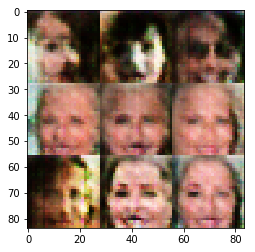

Epoch 1/1... Step 1910... d_loss: 1.4476... g_loss: 0.7442 Elapsed: 25m25s
Epoch 1/1... Step 1920... d_loss: 1.2524... g_loss: 0.8327 Elapsed: 25m25s
Epoch 1/1... Step 1930... d_loss: 1.2391... g_loss: 0.7363 Elapsed: 26m26s
Epoch 1/1... Step 1940... d_loss: 1.1245... g_loss: 0.9947 Elapsed: 26m26s
Epoch 1/1... Step 1950... d_loss: 1.4452... g_loss: 0.6470 Elapsed: 26m26s
Epoch 1/1... Step 1960... d_loss: 1.4391... g_loss: 0.5561 Elapsed: 26m26s
Epoch 1/1... Step 1970... d_loss: 1.2768... g_loss: 0.9875 Elapsed: 26m26s
Epoch 1/1... Step 1980... d_loss: 1.2836... g_loss: 0.8754 Elapsed: 26m26s
Epoch 1/1... Step 1990... d_loss: 1.3396... g_loss: 0.8164 Elapsed: 26m26s
Epoch 1/1... Step 2000... d_loss: 1.4134... g_loss: 0.6590 Elapsed: 26m26s
Sample output


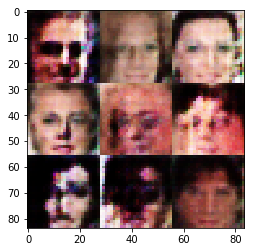

Epoch 1/1... Step 2010... d_loss: 1.3062... g_loss: 1.0220 Elapsed: 27m27s
Epoch 1/1... Step 2020... d_loss: 1.0836... g_loss: 0.9088 Elapsed: 27m27s
Epoch 1/1... Step 2030... d_loss: 1.1478... g_loss: 0.9516 Elapsed: 27m27s
Epoch 1/1... Step 2040... d_loss: 1.0973... g_loss: 0.9467 Elapsed: 27m27s
Epoch 1/1... Step 2050... d_loss: 1.3619... g_loss: 0.7504 Elapsed: 27m27s
Epoch 1/1... Step 2060... d_loss: 1.3642... g_loss: 0.8111 Elapsed: 27m27s
Epoch 1/1... Step 2070... d_loss: 1.4142... g_loss: 0.6899 Elapsed: 27m27s
Epoch 1/1... Step 2080... d_loss: 1.2097... g_loss: 0.8157 Elapsed: 28m28s
Epoch 1/1... Step 2090... d_loss: 1.2064... g_loss: 0.8545 Elapsed: 28m28s
Epoch 1/1... Step 2100... d_loss: 1.3436... g_loss: 0.5855 Elapsed: 28m28s
Sample output


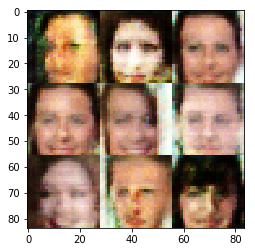

Epoch 1/1... Step 2110... d_loss: 1.1592... g_loss: 0.9235 Elapsed: 28m28s
Epoch 1/1... Step 2120... d_loss: 1.2212... g_loss: 0.8768 Elapsed: 28m28s
Epoch 1/1... Step 2130... d_loss: 1.3261... g_loss: 0.9744 Elapsed: 28m28s
Epoch 1/1... Step 2140... d_loss: 1.1256... g_loss: 1.0700 Elapsed: 28m28s
Epoch 1/1... Step 2150... d_loss: 1.2880... g_loss: 0.6898 Elapsed: 29m29s
Epoch 1/1... Step 2160... d_loss: 1.3005... g_loss: 0.9458 Elapsed: 29m29s
Epoch 1/1... Step 2170... d_loss: 1.1360... g_loss: 1.1258 Elapsed: 29m29s
Epoch 1/1... Step 2180... d_loss: 1.3800... g_loss: 0.6115 Elapsed: 29m29s
Epoch 1/1... Step 2190... d_loss: 1.3854... g_loss: 0.6237 Elapsed: 29m29s
Epoch 1/1... Step 2200... d_loss: 1.2522... g_loss: 0.9430 Elapsed: 29m29s
Sample output


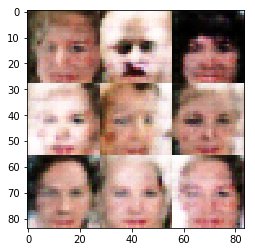

Epoch 1/1... Step 2210... d_loss: 1.1474... g_loss: 0.8525 Elapsed: 29m29s
Epoch 1/1... Step 2220... d_loss: 1.3356... g_loss: 0.6298 Elapsed: 29m29s
Epoch 1/1... Step 2230... d_loss: 1.4132... g_loss: 0.5933 Elapsed: 30m30s
Epoch 1/1... Step 2240... d_loss: 1.4009... g_loss: 0.6791 Elapsed: 30m30s
Epoch 1/1... Step 2250... d_loss: 1.4332... g_loss: 0.6337 Elapsed: 30m30s
Epoch 1/1... Step 2260... d_loss: 1.3283... g_loss: 0.7751 Elapsed: 30m30s
Epoch 1/1... Step 2270... d_loss: 1.4919... g_loss: 0.5605 Elapsed: 30m30s
Epoch 1/1... Step 2280... d_loss: 1.1358... g_loss: 0.8293 Elapsed: 30m30s
Epoch 1/1... Step 2290... d_loss: 1.3292... g_loss: 0.6082 Elapsed: 30m30s
Epoch 1/1... Step 2300... d_loss: 1.2422... g_loss: 0.8320 Elapsed: 31m31s
Sample output


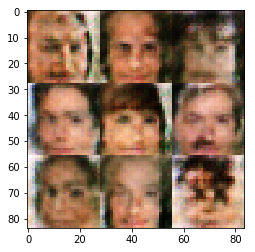

Epoch 1/1... Step 2310... d_loss: 1.0577... g_loss: 0.9383 Elapsed: 31m31s
Epoch 1/1... Step 2320... d_loss: 1.2334... g_loss: 0.7730 Elapsed: 31m31s
Epoch 1/1... Step 2330... d_loss: 1.3299... g_loss: 0.8398 Elapsed: 31m31s
Epoch 1/1... Step 2340... d_loss: 1.1693... g_loss: 0.8293 Elapsed: 31m31s
Epoch 1/1... Step 2350... d_loss: 1.3600... g_loss: 0.6432 Elapsed: 31m31s
Epoch 1/1... Step 2360... d_loss: 1.2804... g_loss: 0.6779 Elapsed: 31m31s
Epoch 1/1... Step 2370... d_loss: 1.2988... g_loss: 0.7871 Elapsed: 31m31s
Epoch 1/1... Step 2380... d_loss: 1.4506... g_loss: 0.7159 Elapsed: 32m32s
Epoch 1/1... Step 2390... d_loss: 1.1422... g_loss: 0.8370 Elapsed: 32m32s
Epoch 1/1... Step 2400... d_loss: 1.2148... g_loss: 0.7122 Elapsed: 32m32s
Sample output


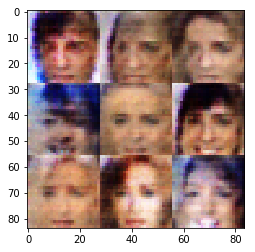

Epoch 1/1... Step 2410... d_loss: 1.0302... g_loss: 0.9208 Elapsed: 32m32s
Epoch 1/1... Step 2420... d_loss: 1.1410... g_loss: 0.7399 Elapsed: 32m32s
Epoch 1/1... Step 2430... d_loss: 1.2473... g_loss: 0.7860 Elapsed: 32m32s
Epoch 1/1... Step 2440... d_loss: 1.1340... g_loss: 0.7871 Elapsed: 32m32s
Epoch 1/1... Step 2450... d_loss: 1.2319... g_loss: 0.7091 Elapsed: 33m33s
Epoch 1/1... Step 2460... d_loss: 1.2800... g_loss: 0.6026 Elapsed: 33m33s
Epoch 1/1... Step 2470... d_loss: 1.1022... g_loss: 0.8470 Elapsed: 33m33s
Epoch 1/1... Step 2480... d_loss: 1.1766... g_loss: 0.7658 Elapsed: 33m33s
Epoch 1/1... Step 2490... d_loss: 1.1426... g_loss: 1.0890 Elapsed: 33m33s
Epoch 1/1... Step 2500... d_loss: 1.4425... g_loss: 0.6391 Elapsed: 33m33s
Sample output


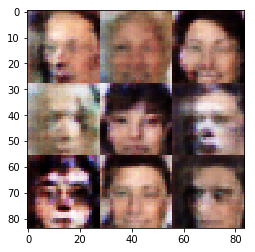

Epoch 1/1... Step 2510... d_loss: 1.2847... g_loss: 0.7394 Elapsed: 33m33s
Epoch 1/1... Step 2520... d_loss: 1.1583... g_loss: 0.8133 Elapsed: 33m33s
Epoch 1/1... Step 2530... d_loss: 1.0981... g_loss: 0.9141 Elapsed: 34m34s
Epoch 1/1... Step 2540... d_loss: 1.3326... g_loss: 0.7087 Elapsed: 34m34s
Epoch 1/1... Step 2550... d_loss: 1.3602... g_loss: 0.7888 Elapsed: 34m34s
Epoch 1/1... Step 2560... d_loss: 1.5115... g_loss: 0.6787 Elapsed: 34m34s
Epoch 1/1... Step 2570... d_loss: 1.0541... g_loss: 1.3077 Elapsed: 34m34s
Epoch 1/1... Step 2580... d_loss: 1.0067... g_loss: 1.0028 Elapsed: 34m34s
Epoch 1/1... Step 2590... d_loss: 1.1807... g_loss: 0.9094 Elapsed: 34m34s
Epoch 1/1... Step 2600... d_loss: 1.5652... g_loss: 0.4449 Elapsed: 35m35s
Sample output


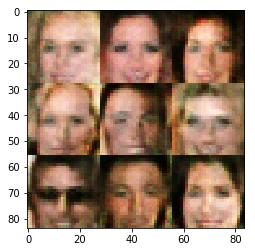

Epoch 1/1... Step 2610... d_loss: 1.2719... g_loss: 0.6666 Elapsed: 35m35s
Epoch 1/1... Step 2620... d_loss: 1.3621... g_loss: 1.0453 Elapsed: 35m35s
Epoch 1/1... Step 2630... d_loss: 1.1948... g_loss: 0.9229 Elapsed: 35m35s
Epoch 1/1... Step 2640... d_loss: 1.1357... g_loss: 0.8322 Elapsed: 35m35s
Epoch 1/1... Step 2650... d_loss: 1.3587... g_loss: 0.8147 Elapsed: 35m35s
Epoch 1/1... Step 2660... d_loss: 1.2291... g_loss: 0.7104 Elapsed: 35m35s
Epoch 1/1... Step 2670... d_loss: 1.2800... g_loss: 0.8783 Elapsed: 36m36s
Epoch 1/1... Step 2680... d_loss: 1.3038... g_loss: 0.7435 Elapsed: 36m36s
Epoch 1/1... Step 2690... d_loss: 1.3698... g_loss: 0.9324 Elapsed: 36m36s
Epoch 1/1... Step 2700... d_loss: 1.2741... g_loss: 0.9103 Elapsed: 36m36s
Sample output


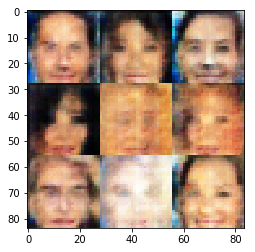

Epoch 1/1... Step 2710... d_loss: 1.1659... g_loss: 0.9720 Elapsed: 36m36s
Epoch 1/1... Step 2720... d_loss: 1.1911... g_loss: 0.7997 Elapsed: 36m36s
Epoch 1/1... Step 2730... d_loss: 1.2962... g_loss: 0.7363 Elapsed: 36m36s
Epoch 1/1... Step 2740... d_loss: 1.2642... g_loss: 0.6772 Elapsed: 36m36s
Epoch 1/1... Step 2750... d_loss: 1.1574... g_loss: 0.9560 Elapsed: 37m37s
Epoch 1/1... Step 2760... d_loss: 1.1852... g_loss: 0.9095 Elapsed: 37m37s
Epoch 1/1... Step 2770... d_loss: 1.2506... g_loss: 0.8100 Elapsed: 37m37s
Epoch 1/1... Step 2780... d_loss: 1.1370... g_loss: 0.9993 Elapsed: 37m37s
Epoch 1/1... Step 2790... d_loss: 1.3289... g_loss: 0.7228 Elapsed: 37m37s
Epoch 1/1... Step 2800... d_loss: 1.4144... g_loss: 0.6850 Elapsed: 37m37s
Sample output


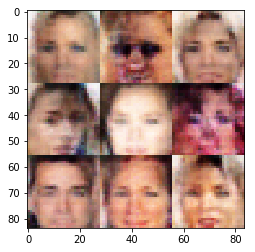

Epoch 1/1... Step 2810... d_loss: 1.1671... g_loss: 0.8351 Elapsed: 37m37s
Epoch 1/1... Step 2820... d_loss: 1.2111... g_loss: 0.8932 Elapsed: 38m38s
Epoch 1/1... Step 2830... d_loss: 1.2169... g_loss: 0.7231 Elapsed: 38m38s
Epoch 1/1... Step 2840... d_loss: 1.5233... g_loss: 0.5378 Elapsed: 38m38s
Epoch 1/1... Step 2850... d_loss: 1.2696... g_loss: 0.7245 Elapsed: 38m38s
Epoch 1/1... Step 2860... d_loss: 1.4330... g_loss: 0.6977 Elapsed: 38m38s
Epoch 1/1... Step 2870... d_loss: 1.1602... g_loss: 0.8135 Elapsed: 38m38s
Epoch 1/1... Step 2880... d_loss: 1.2023... g_loss: 0.7926 Elapsed: 38m38s
Epoch 1/1... Step 2890... d_loss: 1.2612... g_loss: 0.7415 Elapsed: 38m38s
Epoch 1/1... Step 2900... d_loss: 1.2473... g_loss: 0.8463 Elapsed: 39m39s
Sample output


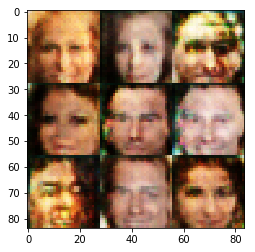

Epoch 1/1... Step 2910... d_loss: 1.3813... g_loss: 0.6808 Elapsed: 39m39s
Epoch 1/1... Step 2920... d_loss: 1.3010... g_loss: 0.8205 Elapsed: 39m39s
Epoch 1/1... Step 2930... d_loss: 1.1993... g_loss: 0.8733 Elapsed: 39m39s
Epoch 1/1... Step 2940... d_loss: 1.2059... g_loss: 0.7881 Elapsed: 39m39s
Epoch 1/1... Step 2950... d_loss: 1.0468... g_loss: 1.0655 Elapsed: 39m39s
Epoch 1/1... Step 2960... d_loss: 1.3169... g_loss: 0.8286 Elapsed: 39m39s
Epoch 1/1... Step 2970... d_loss: 1.2473... g_loss: 0.7615 Elapsed: 40m40s
Epoch 1/1... Step 2980... d_loss: 1.1536... g_loss: 0.9277 Elapsed: 40m40s
Epoch 1/1... Step 2990... d_loss: 1.2133... g_loss: 0.8984 Elapsed: 40m40s
Epoch 1/1... Step 3000... d_loss: 1.3046... g_loss: 0.7946 Elapsed: 40m40s
Sample output


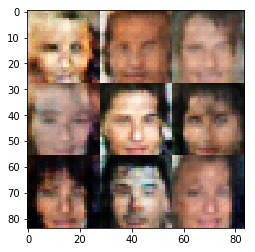

Epoch 1/1... Step 3010... d_loss: 1.2468... g_loss: 0.8678 Elapsed: 40m40s
Epoch 1/1... Step 3020... d_loss: 1.3595... g_loss: 0.7046 Elapsed: 40m40s
Epoch 1/1... Step 3030... d_loss: 1.3002... g_loss: 0.8091 Elapsed: 40m40s
Epoch 1/1... Step 3040... d_loss: 1.1300... g_loss: 0.8109 Elapsed: 41m41s
Epoch 1/1... Step 3050... d_loss: 1.2649... g_loss: 0.7962 Elapsed: 41m41s
Epoch 1/1... Step 3060... d_loss: 1.1958... g_loss: 0.8781 Elapsed: 41m41s
Epoch 1/1... Step 3070... d_loss: 1.3879... g_loss: 0.8799 Elapsed: 41m41s
Epoch 1/1... Step 3080... d_loss: 1.0944... g_loss: 0.9797 Elapsed: 41m41s
Epoch 1/1... Step 3090... d_loss: 1.2355... g_loss: 0.7288 Elapsed: 41m41s
Epoch 1/1... Step 3100... d_loss: 1.3318... g_loss: 0.6948 Elapsed: 41m41s
Sample output


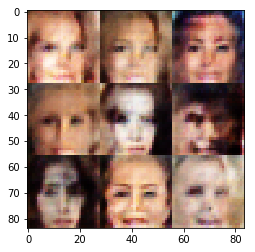

Epoch 1/1... Step 3110... d_loss: 1.3566... g_loss: 0.7343 Elapsed: 41m41s
Epoch 1/1... Step 3120... d_loss: 1.2677... g_loss: 0.6611 Elapsed: 42m42s
Epoch 1/1... Step 3130... d_loss: 1.2731... g_loss: 1.0057 Elapsed: 42m42s
Epoch 1/1... Step 3140... d_loss: 1.0806... g_loss: 0.9374 Elapsed: 42m42s
Epoch 1/1... Step 3150... d_loss: 1.4481... g_loss: 0.6314 Elapsed: 42m42s
Epoch 1/1... Step 3160... d_loss: 1.0795... g_loss: 1.0019 Elapsed: 42m42s
Epoch 1/1... Step 3170... d_loss: 1.1562... g_loss: 0.8820 Elapsed: 42m42s
Epoch 1/1... Step 3180... d_loss: 1.1562... g_loss: 0.9841 Elapsed: 42m42s
Epoch 1/1... Step 3190... d_loss: 1.3295... g_loss: 0.7408 Elapsed: 43m43s
Epoch 1/1... Step 3200... d_loss: 1.2262... g_loss: 0.8578 Elapsed: 43m43s
Sample output


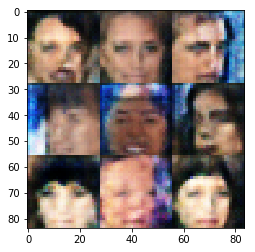

Epoch 1/1... Step 3210... d_loss: 1.3179... g_loss: 0.7115 Elapsed: 43m43s
Epoch 1/1... Step 3220... d_loss: 1.2228... g_loss: 0.8279 Elapsed: 43m43s
Epoch 1/1... Step 3230... d_loss: 1.2641... g_loss: 0.7976 Elapsed: 43m43s
Epoch 1/1... Step 3240... d_loss: 1.0428... g_loss: 1.1240 Elapsed: 43m43s
Epoch 1/1... Step 3250... d_loss: 1.1927... g_loss: 0.8534 Elapsed: 43m43s
Epoch 1/1... Step 3260... d_loss: 1.0747... g_loss: 0.9994 Elapsed: 43m43s
Epoch 1/1... Step 3270... d_loss: 1.4366... g_loss: 0.6130 Elapsed: 44m44s
Epoch 1/1... Step 3280... d_loss: 1.2599... g_loss: 0.7638 Elapsed: 44m44s
Epoch 1/1... Step 3290... d_loss: 1.4125... g_loss: 0.7258 Elapsed: 44m44s
Epoch 1/1... Step 3300... d_loss: 1.0744... g_loss: 0.9726 Elapsed: 44m44s
Sample output


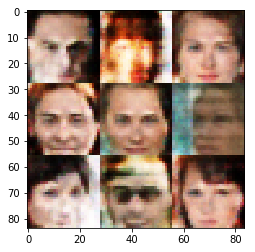

Epoch 1/1... Step 3310... d_loss: 1.1590... g_loss: 0.9932 Elapsed: 44m44s
Epoch 1/1... Step 3320... d_loss: 1.2590... g_loss: 0.8484 Elapsed: 44m44s
Epoch 1/1... Step 3330... d_loss: 1.3084... g_loss: 0.8095 Elapsed: 44m44s
Epoch 1/1... Step 3340... d_loss: 1.1939... g_loss: 0.8209 Elapsed: 45m45s
Epoch 1/1... Step 3350... d_loss: 1.2661... g_loss: 0.7270 Elapsed: 45m45s
Epoch 1/1... Step 3360... d_loss: 1.1987... g_loss: 0.8733 Elapsed: 45m45s
Epoch 1/1... Step 3370... d_loss: 1.2091... g_loss: 0.7566 Elapsed: 45m45s
Epoch 1/1... Step 3380... d_loss: 1.0568... g_loss: 0.9501 Elapsed: 45m45s
Epoch 1/1... Step 3390... d_loss: 1.1954... g_loss: 0.8829 Elapsed: 45m45s
Epoch 1/1... Step 3400... d_loss: 1.4042... g_loss: 0.6232 Elapsed: 45m45s
Sample output


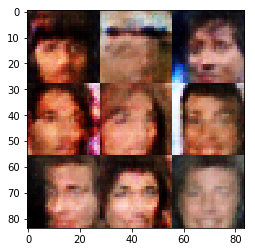

Epoch 1/1... Step 3410... d_loss: 1.2871... g_loss: 0.6699 Elapsed: 46m46s
Epoch 1/1... Step 3420... d_loss: 1.2808... g_loss: 0.9592 Elapsed: 46m46s
Epoch 1/1... Step 3430... d_loss: 1.1171... g_loss: 1.0555 Elapsed: 46m46s
Epoch 1/1... Step 3440... d_loss: 1.1912... g_loss: 0.8611 Elapsed: 46m46s
Epoch 1/1... Step 3450... d_loss: 1.3383... g_loss: 0.7024 Elapsed: 46m46s
Epoch 1/1... Step 3460... d_loss: 1.2770... g_loss: 0.9258 Elapsed: 46m46s
Epoch 1/1... Step 3470... d_loss: 1.2045... g_loss: 0.8216 Elapsed: 46m46s
Epoch 1/1... Step 3480... d_loss: 1.1349... g_loss: 0.8886 Elapsed: 46m46s
Epoch 1/1... Step 3490... d_loss: 1.2131... g_loss: 0.7847 Elapsed: 47m47s
Epoch 1/1... Step 3500... d_loss: 1.1945... g_loss: 0.9148 Elapsed: 47m47s
Sample output


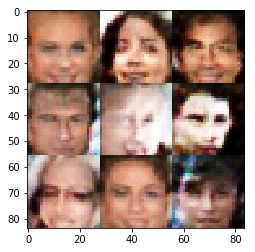

Epoch 1/1... Step 3510... d_loss: 1.2144... g_loss: 0.8935 Elapsed: 47m47s
Epoch 1/1... Step 3520... d_loss: 1.1906... g_loss: 0.9013 Elapsed: 47m47s
Epoch 1/1... Step 3530... d_loss: 1.2155... g_loss: 0.7440 Elapsed: 47m47s
Epoch 1/1... Step 3540... d_loss: 1.2680... g_loss: 0.7744 Elapsed: 47m47s
Epoch 1/1... Step 3550... d_loss: 1.1772... g_loss: 1.0647 Elapsed: 47m47s
Epoch 1/1... Step 3560... d_loss: 1.2692... g_loss: 0.6725 Elapsed: 48m48s
Epoch 1/1... Step 3570... d_loss: 1.1435... g_loss: 0.8745 Elapsed: 48m48s
Epoch 1/1... Step 3580... d_loss: 1.2802... g_loss: 0.7502 Elapsed: 48m48s
Epoch 1/1... Step 3590... d_loss: 1.2590... g_loss: 0.8000 Elapsed: 48m48s
Epoch 1/1... Step 3600... d_loss: 1.2544... g_loss: 0.7196 Elapsed: 48m48s
Sample output


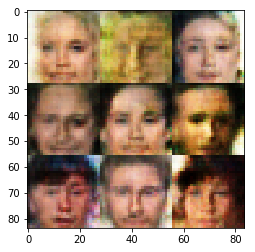

Epoch 1/1... Step 3610... d_loss: 1.2426... g_loss: 0.7411 Elapsed: 48m48s
Epoch 1/1... Step 3620... d_loss: 1.3186... g_loss: 0.7917 Elapsed: 48m48s
Epoch 1/1... Step 3630... d_loss: 1.3110... g_loss: 0.7498 Elapsed: 48m48s
Epoch 1/1... Step 3640... d_loss: 1.2878... g_loss: 0.8151 Elapsed: 49m49s
Epoch 1/1... Step 3650... d_loss: 1.1670... g_loss: 0.8792 Elapsed: 49m49s
Epoch 1/1... Step 3660... d_loss: 1.4642... g_loss: 0.7759 Elapsed: 49m49s
Epoch 1/1... Step 3670... d_loss: 1.2900... g_loss: 1.0711 Elapsed: 49m49s
Epoch 1/1... Step 3680... d_loss: 1.3491... g_loss: 0.8233 Elapsed: 49m49s
Epoch 1/1... Step 3690... d_loss: 1.2049... g_loss: 0.9042 Elapsed: 49m49s
Epoch 1/1... Step 3700... d_loss: 1.2523... g_loss: 0.8356 Elapsed: 49m49s
Sample output


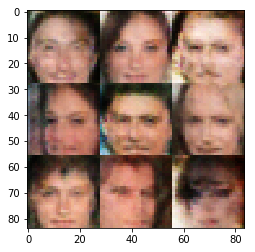

Epoch 1/1... Step 3710... d_loss: 1.2575... g_loss: 0.7847 Elapsed: 50m50s
Epoch 1/1... Step 3720... d_loss: 1.0820... g_loss: 1.0006 Elapsed: 50m50s
Epoch 1/1... Step 3730... d_loss: 1.2085... g_loss: 0.9466 Elapsed: 50m50s
Epoch 1/1... Step 3740... d_loss: 1.1599... g_loss: 0.8104 Elapsed: 50m50s
Epoch 1/1... Step 3750... d_loss: 1.2694... g_loss: 0.8054 Elapsed: 50m50s
Epoch 1/1... Step 3760... d_loss: 1.2034... g_loss: 0.9006 Elapsed: 50m50s
Epoch 1/1... Step 3770... d_loss: 1.1724... g_loss: 0.9458 Elapsed: 50m50s
Epoch 1/1... Step 3780... d_loss: 1.1536... g_loss: 0.8275 Elapsed: 50m50s
Epoch 1/1... Step 3790... d_loss: 1.2771... g_loss: 0.6999 Elapsed: 51m51s
Epoch 1/1... Step 3800... d_loss: 1.3161... g_loss: 0.6717 Elapsed: 51m51s
Sample output


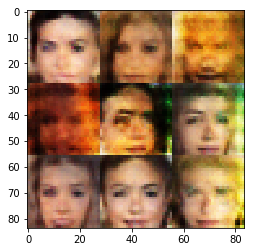

Epoch 1/1... Step 3810... d_loss: 1.3011... g_loss: 0.7792 Elapsed: 51m51s
Epoch 1/1... Step 3820... d_loss: 1.1095... g_loss: 0.9058 Elapsed: 51m51s
Epoch 1/1... Step 3830... d_loss: 1.2274... g_loss: 0.9113 Elapsed: 51m51s
Epoch 1/1... Step 3840... d_loss: 1.2346... g_loss: 0.8203 Elapsed: 51m51s
Epoch 1/1... Step 3850... d_loss: 1.1419... g_loss: 0.8713 Elapsed: 51m51s
Epoch 1/1... Step 3860... d_loss: 1.0768... g_loss: 0.9555 Elapsed: 52m52s
Epoch 1/1... Step 3870... d_loss: 1.3743... g_loss: 0.6667 Elapsed: 52m52s
Epoch 1/1... Step 3880... d_loss: 1.2699... g_loss: 0.7916 Elapsed: 52m52s
Epoch 1/1... Step 3890... d_loss: 1.1945... g_loss: 0.7874 Elapsed: 52m52s
Epoch 1/1... Step 3900... d_loss: 1.2051... g_loss: 0.8967 Elapsed: 52m52s
Sample output


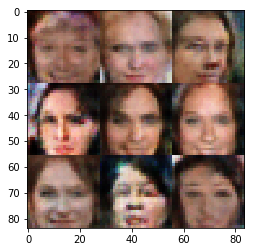

Epoch 1/1... Step 3910... d_loss: 1.4064... g_loss: 0.6870 Elapsed: 52m52s
Epoch 1/1... Step 3920... d_loss: 1.2656... g_loss: 0.8666 Elapsed: 52m52s
Epoch 1/1... Step 3930... d_loss: 1.1475... g_loss: 0.8721 Elapsed: 53m53s
Epoch 1/1... Step 3940... d_loss: 1.3627... g_loss: 0.7499 Elapsed: 53m53s
Epoch 1/1... Step 3950... d_loss: 1.2588... g_loss: 0.7603 Elapsed: 53m53s
Epoch 1/1... Step 3960... d_loss: 1.3127... g_loss: 0.6891 Elapsed: 53m53s
Epoch 1/1... Step 3970... d_loss: 1.2736... g_loss: 0.9005 Elapsed: 53m53s
Epoch 1/1... Step 3980... d_loss: 1.1385... g_loss: 0.8941 Elapsed: 53m53s
Epoch 1/1... Step 3990... d_loss: 1.1428... g_loss: 0.8560 Elapsed: 53m53s
Epoch 1/1... Step 4000... d_loss: 1.1544... g_loss: 1.1074 Elapsed: 53m53s
Sample output


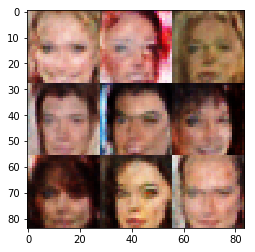

Epoch 1/1... Step 4010... d_loss: 1.4486... g_loss: 0.6565 Elapsed: 54m54s
Epoch 1/1... Step 4020... d_loss: 1.3643... g_loss: 0.7772 Elapsed: 54m54s
Epoch 1/1... Step 4030... d_loss: 1.3194... g_loss: 0.7973 Elapsed: 54m54s
Epoch 1/1... Step 4040... d_loss: 1.0670... g_loss: 0.9866 Elapsed: 54m54s
Epoch 1/1... Step 4050... d_loss: 1.2622... g_loss: 0.9535 Elapsed: 54m54s
Epoch 1/1... Step 4060... d_loss: 1.1868... g_loss: 0.9098 Elapsed: 54m54s
Epoch 1/1... Step 4070... d_loss: 1.3852... g_loss: 0.6349 Elapsed: 54m54s
Epoch 1/1... Step 4080... d_loss: 1.2449... g_loss: 0.8325 Elapsed: 55m55s
Epoch 1/1... Step 4090... d_loss: 1.2354... g_loss: 0.8522 Elapsed: 55m55s
Epoch 1/1... Step 4100... d_loss: 1.4391... g_loss: 0.6609 Elapsed: 55m55s
Sample output


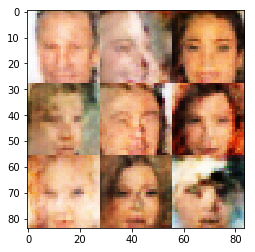

Epoch 1/1... Step 4110... d_loss: 1.1211... g_loss: 0.9056 Elapsed: 55m55s
Epoch 1/1... Step 4120... d_loss: 1.2923... g_loss: 0.8351 Elapsed: 55m55s
Epoch 1/1... Step 4130... d_loss: 1.2008... g_loss: 0.9306 Elapsed: 55m55s
Epoch 1/1... Step 4140... d_loss: 1.2567... g_loss: 0.7660 Elapsed: 55m55s
Epoch 1/1... Step 4150... d_loss: 1.1299... g_loss: 0.9857 Elapsed: 56m56s
Epoch 1/1... Step 4160... d_loss: 1.2243... g_loss: 0.8361 Elapsed: 56m56s
Epoch 1/1... Step 4170... d_loss: 1.2069... g_loss: 0.8870 Elapsed: 56m56s
Epoch 1/1... Step 4180... d_loss: 1.1902... g_loss: 0.8331 Elapsed: 56m56s
Epoch 1/1... Step 4190... d_loss: 1.4160... g_loss: 0.6498 Elapsed: 56m56s
Epoch 1/1... Step 4200... d_loss: 1.2172... g_loss: 0.7964 Elapsed: 56m56s
Sample output


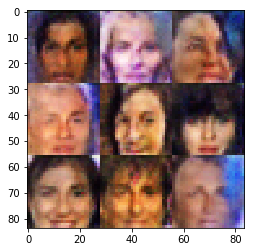

Epoch 1/1... Step 4210... d_loss: 1.2926... g_loss: 0.8324 Elapsed: 56m56s
Epoch 1/1... Step 4220... d_loss: 1.1874... g_loss: 0.8188 Elapsed: 56m56s
Epoch 1/1... Step 4230... d_loss: 1.3263... g_loss: 0.6854 Elapsed: 57m57s
Epoch 1/1... Step 4240... d_loss: 1.3296... g_loss: 0.8314 Elapsed: 57m57s
Epoch 1/1... Step 4250... d_loss: 1.0733... g_loss: 0.9538 Elapsed: 57m57s
Epoch 1/1... Step 4260... d_loss: 1.3000... g_loss: 0.7269 Elapsed: 57m57s
Epoch 1/1... Step 4270... d_loss: 1.2426... g_loss: 0.7658 Elapsed: 57m57s
Epoch 1/1... Step 4280... d_loss: 1.1871... g_loss: 0.8536 Elapsed: 57m57s
Epoch 1/1... Step 4290... d_loss: 1.3646... g_loss: 0.7061 Elapsed: 57m57s
Epoch 1/1... Step 4300... d_loss: 1.3119... g_loss: 0.7393 Elapsed: 58m58s
Sample output


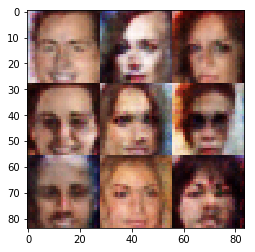

Epoch 1/1... Step 4310... d_loss: 1.1835... g_loss: 0.8849 Elapsed: 58m58s
Epoch 1/1... Step 4320... d_loss: 1.2325... g_loss: 0.7262 Elapsed: 58m58s
Epoch 1/1... Step 4330... d_loss: 1.2461... g_loss: 0.8352 Elapsed: 58m58s
Epoch 1/1... Step 4340... d_loss: 1.3568... g_loss: 0.6528 Elapsed: 58m58s
Epoch 1/1... Step 4350... d_loss: 1.3985... g_loss: 0.6763 Elapsed: 58m58s
Epoch 1/1... Step 4360... d_loss: 1.1900... g_loss: 0.7627 Elapsed: 58m58s
Epoch 1/1... Step 4370... d_loss: 1.4179... g_loss: 0.7239 Elapsed: 58m58s
Epoch 1/1... Step 4380... d_loss: 1.1967... g_loss: 0.9046 Elapsed: 59m59s
Epoch 1/1... Step 4390... d_loss: 1.1856... g_loss: 0.8106 Elapsed: 59m59s
Epoch 1/1... Step 4400... d_loss: 1.2387... g_loss: 0.8214 Elapsed: 59m59s
Sample output


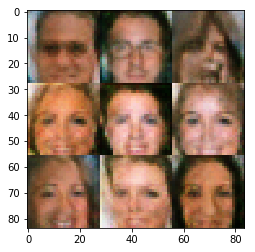

Epoch 1/1... Step 4410... d_loss: 1.2069... g_loss: 0.8182 Elapsed: 59m59s
Epoch 1/1... Step 4420... d_loss: 1.2446... g_loss: 0.8073 Elapsed: 59m59s
Epoch 1/1... Step 4430... d_loss: 1.2355... g_loss: 0.8232 Elapsed: 59m59s
Epoch 1/1... Step 4440... d_loss: 1.0760... g_loss: 0.9317 Elapsed: 59m59s
Epoch 1/1... Step 4450... d_loss: 1.2090... g_loss: 0.8329 Elapsed: 60m60s
Epoch 1/1... Step 4460... d_loss: 1.2583... g_loss: 0.8439 Elapsed: 60m60s
Epoch 1/1... Step 4470... d_loss: 1.2579... g_loss: 0.8661 Elapsed: 60m60s
Epoch 1/1... Step 4480... d_loss: 1.4026... g_loss: 0.7261 Elapsed: 60m60s
Epoch 1/1... Step 4490... d_loss: 1.2625... g_loss: 0.8544 Elapsed: 60m60s
Epoch 1/1... Step 4500... d_loss: 1.3068... g_loss: 0.8138 Elapsed: 60m60s
Sample output


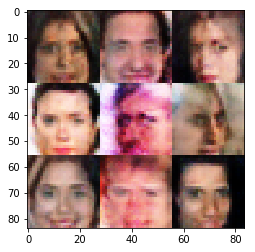

Epoch 1/1... Step 4510... d_loss: 1.1003... g_loss: 0.9714 Elapsed: 60m60s
Epoch 1/1... Step 4520... d_loss: 1.2418... g_loss: 0.7840 Elapsed: 61m61s
Epoch 1/1... Step 4530... d_loss: 1.2568... g_loss: 0.7384 Elapsed: 61m61s
Epoch 1/1... Step 4540... d_loss: 1.2989... g_loss: 0.6853 Elapsed: 61m61s
Epoch 1/1... Step 4550... d_loss: 1.2926... g_loss: 0.7562 Elapsed: 61m61s
Epoch 1/1... Step 4560... d_loss: 1.3464... g_loss: 0.7603 Elapsed: 61m61s
Epoch 1/1... Step 4570... d_loss: 1.2061... g_loss: 0.8505 Elapsed: 62m62s
Epoch 1/1... Step 4580... d_loss: 1.2732... g_loss: 0.8833 Elapsed: 62m62s
Epoch 1/1... Step 4590... d_loss: 1.1838... g_loss: 0.9120 Elapsed: 63m63s
Epoch 1/1... Step 4600... d_loss: 1.0800... g_loss: 1.0371 Elapsed: 63m63s
Sample output


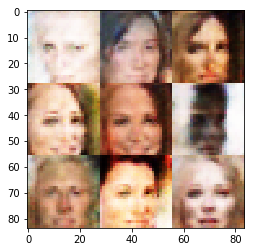

Epoch 1/1... Step 4610... d_loss: 1.2627... g_loss: 0.7384 Elapsed: 64m64s
Epoch 1/1... Step 4620... d_loss: 1.2828... g_loss: 0.7256 Elapsed: 64m64s
Epoch 1/1... Step 4630... d_loss: 1.3325... g_loss: 0.7768 Elapsed: 65m65s
Epoch 1/1... Step 4640... d_loss: 1.2250... g_loss: 0.8201 Elapsed: 65m65s
Epoch 1/1... Step 4650... d_loss: 1.2223... g_loss: 0.8501 Elapsed: 66m66s
Epoch 1/1... Step 4660... d_loss: 1.2074... g_loss: 0.8764 Elapsed: 67m67s
Epoch 1/1... Step 4670... d_loss: 1.2335... g_loss: 0.8030 Elapsed: 67m67s
Epoch 1/1... Step 4680... d_loss: 1.2484... g_loss: 0.9047 Elapsed: 68m68s
Epoch 1/1... Step 4690... d_loss: 1.3539... g_loss: 0.7066 Elapsed: 68m68s
Epoch 1/1... Step 4700... d_loss: 1.3589... g_loss: 0.7589 Elapsed: 69m69s
Sample output


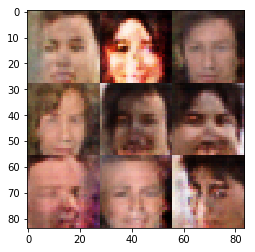

Epoch 1/1... Step 4710... d_loss: 1.1705... g_loss: 0.8435 Elapsed: 69m69s
Epoch 1/1... Step 4720... d_loss: 1.3046... g_loss: 0.7643 Elapsed: 70m70s
Epoch 1/1... Step 4730... d_loss: 1.2833... g_loss: 0.8001 Elapsed: 70m70s
Epoch 1/1... Step 4740... d_loss: 1.2052... g_loss: 0.8056 Elapsed: 71m71s
Epoch 1/1... Step 4750... d_loss: 1.5980... g_loss: 0.5142 Elapsed: 72m72s
Epoch 1/1... Step 4760... d_loss: 1.2506... g_loss: 0.7661 Elapsed: 72m72s
Epoch 1/1... Step 4770... d_loss: 1.2222... g_loss: 0.8426 Elapsed: 73m73s
Epoch 1/1... Step 4780... d_loss: 1.2599... g_loss: 0.6686 Elapsed: 73m73s
Epoch 1/1... Step 4790... d_loss: 1.1314... g_loss: 0.8960 Elapsed: 74m74s
Epoch 1/1... Step 4800... d_loss: 1.1866... g_loss: 0.8153 Elapsed: 74m74s
Sample output


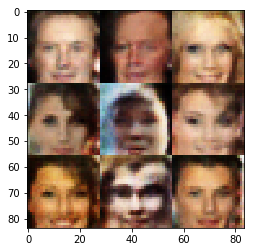

Epoch 1/1... Step 4810... d_loss: 1.5210... g_loss: 0.6089 Elapsed: 75m75s
Epoch 1/1... Step 4820... d_loss: 1.2687... g_loss: 0.7769 Elapsed: 76m76s
Epoch 1/1... Step 4830... d_loss: 1.2493... g_loss: 0.8379 Elapsed: 76m76s
Epoch 1/1... Step 4840... d_loss: 1.1897... g_loss: 0.7811 Elapsed: 77m77s
Epoch 1/1... Step 4850... d_loss: 1.1548... g_loss: 1.0127 Elapsed: 77m77s
Epoch 1/1... Step 4860... d_loss: 1.3678... g_loss: 0.8118 Elapsed: 78m78s
Epoch 1/1... Step 4870... d_loss: 1.2919... g_loss: 0.8033 Elapsed: 78m78s
Epoch 1/1... Step 4880... d_loss: 1.1718... g_loss: 0.8799 Elapsed: 79m79s
Epoch 1/1... Step 4890... d_loss: 1.2038... g_loss: 0.8888 Elapsed: 80m80s
Epoch 1/1... Step 4900... d_loss: 1.3608... g_loss: 0.7402 Elapsed: 80m80s
Sample output


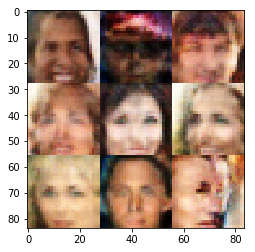

Epoch 1/1... Step 4910... d_loss: 1.3637... g_loss: 0.7375 Elapsed: 81m81s
Epoch 1/1... Step 4920... d_loss: 1.3484... g_loss: 0.7834 Elapsed: 81m81s
Epoch 1/1... Step 4930... d_loss: 1.2838... g_loss: 0.7923 Elapsed: 82m82s
Epoch 1/1... Step 4940... d_loss: 1.3158... g_loss: 0.7745 Elapsed: 83m83s
Epoch 1/1... Step 4950... d_loss: 1.2653... g_loss: 0.7814 Elapsed: 84m84s
Epoch 1/1... Step 4960... d_loss: 1.5885... g_loss: 0.6226 Elapsed: 84m84s
Epoch 1/1... Step 4970... d_loss: 1.3919... g_loss: 0.7074 Elapsed: 85m85s
Epoch 1/1... Step 4980... d_loss: 1.3338... g_loss: 0.7933 Elapsed: 85m85s
Epoch 1/1... Step 4990... d_loss: 1.3290... g_loss: 0.7132 Elapsed: 86m86s
Epoch 1/1... Step 5000... d_loss: 1.1737... g_loss: 0.8523 Elapsed: 87m87s
Sample output


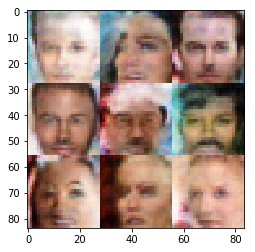

Epoch 1/1... Step 5010... d_loss: 1.2681... g_loss: 0.8240 Elapsed: 87m87s
Epoch 1/1... Step 5020... d_loss: 1.3161... g_loss: 0.7728 Elapsed: 88m88s
Epoch 1/1... Step 5030... d_loss: 1.3294... g_loss: 0.7210 Elapsed: 89m89s
Epoch 1/1... Step 5040... d_loss: 1.1061... g_loss: 0.8309 Elapsed: 89m89s
Epoch 1/1... Step 5050... d_loss: 1.2616... g_loss: 0.8006 Elapsed: 90m90s
Epoch 1/1... Step 5060... d_loss: 1.2270... g_loss: 0.8251 Elapsed: 90m90s
Epoch 1/1... Step 5070... d_loss: 1.1858... g_loss: 0.8726 Elapsed: 91m91s
Epoch 1/1... Step 5080... d_loss: 1.3140... g_loss: 0.8145 Elapsed: 92m92s
Epoch 1/1... Step 5090... d_loss: 1.3124... g_loss: 0.6756 Elapsed: 92m92s
Epoch 1/1... Step 5100... d_loss: 1.2759... g_loss: 0.7625 Elapsed: 93m93s
Sample output


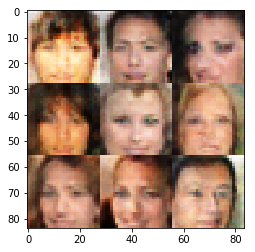

Epoch 1/1... Step 5110... d_loss: 1.2834... g_loss: 0.7640 Elapsed: 94m94s
Epoch 1/1... Step 5120... d_loss: 1.3581... g_loss: 0.7513 Elapsed: 94m94s
Epoch 1/1... Step 5130... d_loss: 1.4467... g_loss: 0.6351 Elapsed: 95m95s
Epoch 1/1... Step 5140... d_loss: 1.3387... g_loss: 0.7862 Elapsed: 96m96s
Epoch 1/1... Step 5150... d_loss: 1.3002... g_loss: 0.8031 Elapsed: 97m97s
Epoch 1/1... Step 5160... d_loss: 1.1301... g_loss: 0.8923 Elapsed: 97m97s
Epoch 1/1... Step 5170... d_loss: 1.2252... g_loss: 0.8580 Elapsed: 98m98s
Epoch 1/1... Step 5180... d_loss: 1.2061... g_loss: 0.8283 Elapsed: 99m99s
Epoch 1/1... Step 5190... d_loss: 1.1934... g_loss: 0.8695 Elapsed: 100m100s
Epoch 1/1... Step 5200... d_loss: 1.1801... g_loss: 0.8802 Elapsed: 100m100s
Sample output


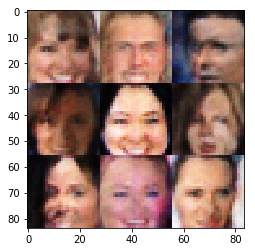

Epoch 1/1... Step 5210... d_loss: 1.1421... g_loss: 0.8894 Elapsed: 101m101s
Epoch 1/1... Step 5220... d_loss: 1.3389... g_loss: 0.7041 Elapsed: 102m102s
Epoch 1/1... Step 5230... d_loss: 1.2872... g_loss: 0.7683 Elapsed: 103m103s
Epoch 1/1... Step 5240... d_loss: 1.3974... g_loss: 0.6664 Elapsed: 103m103s
Epoch 1/1... Step 5250... d_loss: 1.1361... g_loss: 0.8404 Elapsed: 104m104s
Epoch 1/1... Step 5260... d_loss: 1.4127... g_loss: 0.6157 Elapsed: 105m105s
Epoch 1/1... Step 5270... d_loss: 1.1868... g_loss: 0.8411 Elapsed: 105m105s
Epoch 1/1... Step 5280... d_loss: 1.5137... g_loss: 0.6135 Elapsed: 106m106s
Epoch 1/1... Step 5290... d_loss: 1.4856... g_loss: 0.6120 Elapsed: 107m107s
Epoch 1/1... Step 5300... d_loss: 1.1333... g_loss: 0.9203 Elapsed: 108m108s
Sample output


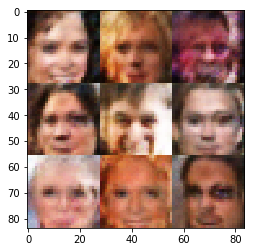

Epoch 1/1... Step 5310... d_loss: 1.4252... g_loss: 0.6957 Elapsed: 108m108s
Epoch 1/1... Step 5320... d_loss: 1.1714... g_loss: 0.8946 Elapsed: 109m109s
Epoch 1/1... Step 5330... d_loss: 1.3632... g_loss: 0.6896 Elapsed: 110m110s
Epoch 1/1... Step 5340... d_loss: 1.3115... g_loss: 0.7866 Elapsed: 111m111s
Epoch 1/1... Step 5350... d_loss: 1.1757... g_loss: 0.8308 Elapsed: 111m111s
Epoch 1/1... Step 5360... d_loss: 1.2021... g_loss: 0.8660 Elapsed: 112m112s
Epoch 1/1... Step 5370... d_loss: 1.2249... g_loss: 0.8968 Elapsed: 113m113s
Epoch 1/1... Step 5380... d_loss: 1.2012... g_loss: 0.8102 Elapsed: 114m114s
Epoch 1/1... Step 5390... d_loss: 1.4210... g_loss: 0.6400 Elapsed: 114m114s
Epoch 1/1... Step 5400... d_loss: 1.2571... g_loss: 0.8068 Elapsed: 115m115s
Sample output


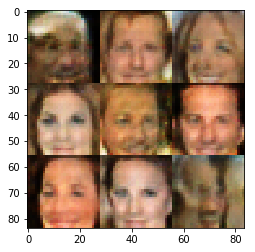

Epoch 1/1... Step 5410... d_loss: 1.2870... g_loss: 0.8178 Elapsed: 116m116s
Epoch 1/1... Step 5420... d_loss: 1.2415... g_loss: 0.7931 Elapsed: 116m116s
Epoch 1/1... Step 5430... d_loss: 1.3470... g_loss: 0.7073 Elapsed: 117m117s
Epoch 1/1... Step 5440... d_loss: 1.3144... g_loss: 0.7756 Elapsed: 118m118s
Epoch 1/1... Step 5450... d_loss: 1.2130... g_loss: 0.8169 Elapsed: 119m119s
Epoch 1/1... Step 5460... d_loss: 1.2632... g_loss: 0.8349 Elapsed: 119m119s
Epoch 1/1... Step 5470... d_loss: 1.2374... g_loss: 0.8098 Elapsed: 120m120s
Epoch 1/1... Step 5480... d_loss: 1.2844... g_loss: 0.8097 Elapsed: 121m121s
Epoch 1/1... Step 5490... d_loss: 1.3669... g_loss: 0.6394 Elapsed: 122m122s
Epoch 1/1... Step 5500... d_loss: 1.2109... g_loss: 0.7957 Elapsed: 122m122s
Sample output


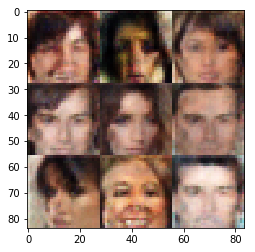

Epoch 1/1... Step 5510... d_loss: 1.2853... g_loss: 0.8098 Elapsed: 123m123s
Epoch 1/1... Step 5520... d_loss: 1.3757... g_loss: 0.7331 Elapsed: 124m124s
Epoch 1/1... Step 5530... d_loss: 1.5432... g_loss: 0.6157 Elapsed: 125m125s
Epoch 1/1... Step 5540... d_loss: 1.2656... g_loss: 0.7883 Elapsed: 125m125s
Epoch 1/1... Step 5550... d_loss: 1.3220... g_loss: 0.7746 Elapsed: 126m126s
Epoch 1/1... Step 5560... d_loss: 1.4186... g_loss: 0.6695 Elapsed: 127m127s


KeyboardInterrupt: 

In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.